Семестровая по машинному обучению на тему «предсказание возраста морского ушка»

Источник данных:
https://archive.ics.uci.edu/ml/datasets/Abalone

Морское ушко (или галиотисы) – род моллюсков (насчитывает 51 вид). Раковина по форме похожа на человеческое ухо с маленьким, плоским завитком сбоку на заднем конце, с очень широким входом, с развитым перламутровым слоем и рядом отверстий вдоль левого края. Моллюск больше раковины, с широкой, по края бахромчатой ногой и глубоким щелевидным вырезом мантии (который соответствует ряду отверстий раковины). Морда короткая, глаза на коротких стебельках. Средние размеры галиотисов составляют 5-7 см, но представители отдельных видов достигают 35 см в длину.

Обычно возраст измеряют разрезанием раковины и подсчитыванием колец, но это скучная и времязатратная процедура. В данной работе делается попытка предсказать возраст морского ушка на основе её размера и веса.

Датасет основывается на исследовании популяции морских ушек содержит данные о 4177 особях вида Haliotis rubra из Тасмании.  У этого вида есть два подвида - Haliotis rubra conicopora и Haliotis rubra rubra. Из оригинального датасета были удалены все примеры с пропущенными значениями, а непрерывные величины были отмасштабированы (разделены на 200). Обратите внимание — это было сделано ещё до публикации датасета, т.е. датасет, который мы получаем, уже отфильтрован и отмасштабирован.

Имеющиеся признаки:
 * Sex – M, F или I (infant)
 * Length – самое длинное измерение раковины
 * Diameter – перпендикулярно длине
 * Height – высота, включая мясо
 * Whole weight – общий вес 
 * Shucked weight – вес мяса
 * Viscera weight – вес внутренностей
 * Shell weight – вес раковины
 * Rings – количество колец; если прибавить 1,5, то получим возраст в годах.
 
Нам нужно предсказать значение на основе данных, поэтому это задача регрессии. Возможно, также имеет смысл рассмотреть эту задачу как задачу кластеризации – известно, что этот вид делится на два подвида, но отдельного признака для них нет и неизвестно, есть ли там данные о двух подвидах или только о каком-то одном. Полученные кластеризацией данные можно использовать для увеличения точности регрессии.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Читаем данные. Названия заголовков даны в файле abalone.names, они были вписаны здесь вручную для удобства. Переведём размер и вес в миллиметры и граммы (нормализуем потом сами).

In [2]:
filename = "abalone.data"
columns = ["Sex", "Length", "Diameter",
           "Height", "Whole", "Shucked",
           "Viscera", "Shell", "Rings"]

df = pd.read_csv(filename, names = columns)

continous_columns = ["Length", "Diameter","Height", "Whole", "Shucked","Viscera", "Shell"]
for c in continous_columns:
    df[c] = df[c] * 200
    
df.head()

,Sex,Length,Diameter,Height,Whole,Shucked,Viscera,Shell,Rings
0,M,91.0,73.0,19.0,102.8,44.9,20.2,30.0,15
1,M,70.0,53.0,18.0,45.1,19.9,9.7,14.0,7
2,F,106.0,84.0,27.0,135.4,51.3,28.3,42.0,9
3,M,88.0,73.0,25.0,103.2,43.1,22.8,31.0,10
4,I,66.0,51.0,16.0,41.0,17.9,7.9,11.0,7


Посмотрим распределение данных.

,Length,Diameter,Height,Whole,Shucked,Viscera,Shell,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,104.798420,81.576251,27.903280,165.748432,71.873498,36.118722,47.766172,9.933684
std,24.018583,19.847973,8.365411,98.077804,44.392590,21.922850,27.840534,3.224169
min,15.000000,11.000000,0.000000,0.400000,0.200000,0.100000,0.300000,1.000000
25%,90.000000,70.000000,23.000000,88.300000,37.200000,18.700000,26.000000,8.000000
50%,109.000000,85.000000,28.000000,159.900000,67.200000,34.200000,46.800000,9.000000
75%,123.000000,96.000000,33.000000,230.600000,100.400000,50.600000,65.800000,11.000000
max,163.000000,130.000000,226.000000,565.100000,297.600000,152.000000,201.000000,29.000000


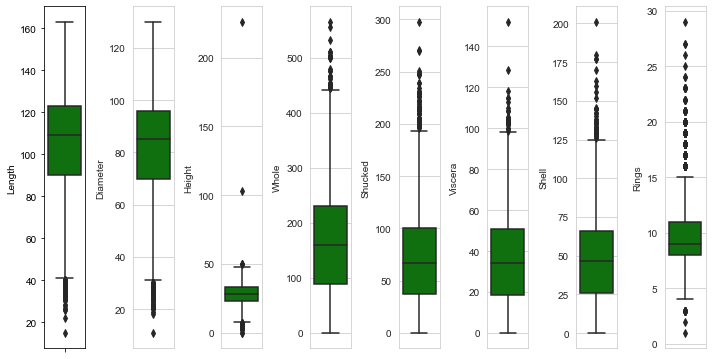

In [3]:
l = df.loc[:, 'Length':].columns.values
number_of_columns = len(l)
number_of_rows = 1
plt.figure(figsize=(10,10))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1, number_of_columns,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(y=df[l[i]],color='green',orient='v')
    plt.tight_layout()
    
df.describe()

Заметны следующие выбросы:
 * Высота больше 100
 * Вес мяса больше 0,6
 * Вес ракушки больше 0,8
 * Высота может равняться нулю
 
 Убираем, строим график снова.

,Length,Diameter,Height,Whole,Shucked,Viscera,Shell,Rings
count,4163.000000,4163.000000,4163.000000,4163.000000,4163.000000,4163.000000,4163.000000,4163.00000
mean,104.710545,81.498919,27.811914,165.020538,71.557603,35.978645,47.506173,9.92025
std,23.955701,19.788859,7.639771,96.936961,43.847952,21.706667,27.339418,3.20580
min,15.000000,11.000000,2.000000,0.400000,0.200000,0.100000,0.300000,1.00000
25%,90.000000,70.000000,23.000000,88.250000,37.200000,18.600000,26.000000,8.00000
50%,109.000000,85.000000,28.000000,159.600000,67.100000,34.000000,46.500000,9.00000
75%,123.000000,96.000000,33.000000,230.000000,100.100000,50.400000,65.150000,11.00000
max,163.000000,130.000000,50.000000,511.000000,250.600000,118.000000,159.500000,29.00000


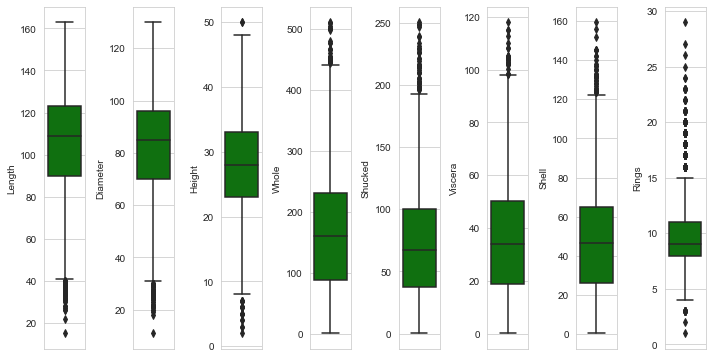

In [4]:
df.drop(df[df["Height"] > 100].index, axis=0, inplace=True)
df.drop(df[df["Shucked"] > 260].index, axis=0, inplace=True)
df.drop(df[df["Viscera"] > 120].index, axis=0, inplace=True)
df.drop(df[df["Shell"] > 160].index, axis=0, inplace=True)

df.drop(df[df["Height"] == 0].index, axis=0, inplace=True)

l = df.loc[:, 'Length':].columns.values
number_of_columns = len(l)
number_of_rows = 1
plt.figure(figsize=(10,10))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1, number_of_columns,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(y=df[l[i]],color='green',orient='v')
    plt.tight_layout()
    
df.describe()

Видно следующее:
 * Размер измерялся с точностью до миллиметра
 * Вес измерялся с точностью до десятых грамма

Посмотрим распределение для каждого пола отдельно

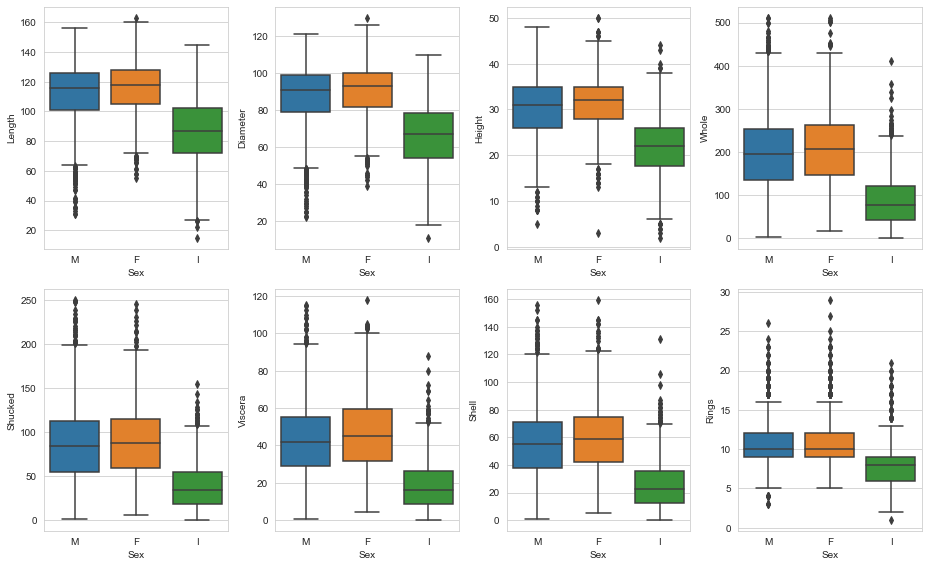

In [5]:
l = df.loc[:, 'Length':].columns
number_of_rows=len(l)
plt.figure(figsize=(13,35))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,4,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(x="Sex", y=l[i], data=df, orient='v')
    plt.tight_layout()

Видно, что женские особи слегка больше мужских, но в целом кардинальных отличий нет; дети, естественно, младше и меньше.

Посмотрим зависимости между признаками.

<AxesSubplot:>

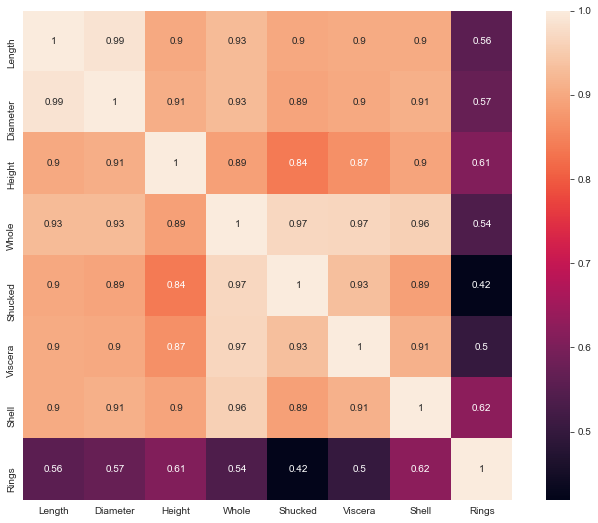

In [6]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, square=True, annot=True)

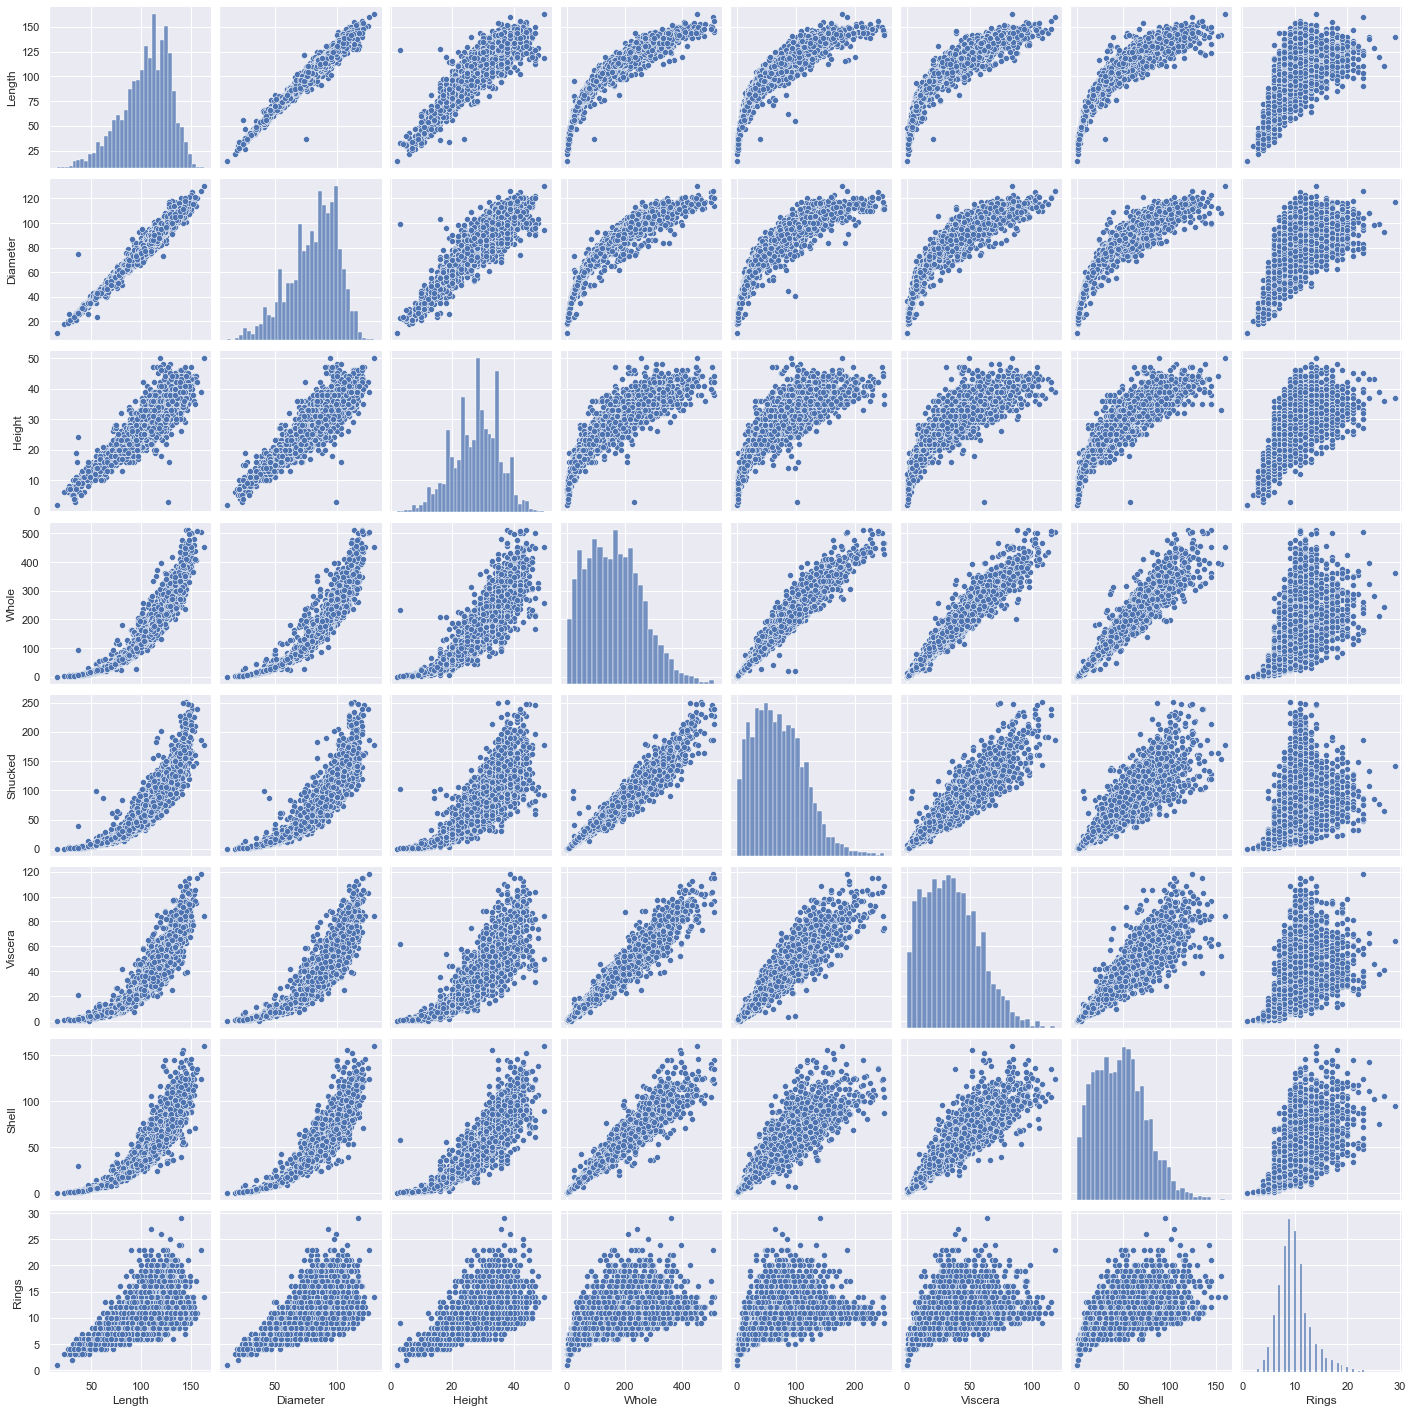

In [7]:
sns.set()
sns.pairplot(df)
plt.show();

Видны следующие закономерности:
 * Длина, диаметр и высота примерно линейно зависят друг от друга
 * Общий вес и вес частей примерно линейно зависят друг от друга
 * Вес зависит от размера нелинейно. Предположение — кубическая зависимость (т.е. плотность разных ушек примерно одинаковая). Проверим это утверждение чуть позже.

Создадим новые признаки:
 * Пол кодируем через one-hot encoding
 * Создаём признак возраст, т.к. нам надо предсказывать именно его
 * Считаем объём и плотность. Объём, очевидно, считается неверно - мы находим объём параллелепипеда, в который ушко можно вписать, само ушко должно быть меньше. Так как все ушки одинаковой формы, то для нахождения реального объёма достаточно умножить полученный нами объём на коэффициент, показывающий, какую долю параллелепипеда занимает ушко, вписанное в него; но объём нам и не нужен точно; нам лишь нужно проверить, что вес линейно зависит от произведения размеров ушка, так что с этим можно не заморачиваться.

In [8]:
df["IsMale"] = (df["Sex"]=="M").astype(int)
df["IsFemale"] = (df["Sex"]=="F").astype(int)
df["Age"] = df["Rings"] + 1.5
df["Volume"] = df["Length"]*df["Height"]*df["Diameter"]
df["ShellDensity"] = df["Shell"] / df["Volume"]
df["WholeDensity"] = df["Whole"] / df["Volume"]
df["VisceraDensity"] = df["Viscera"] / df["Volume"]
df["ShuckedDensity"] = df["Shucked"] / df["Volume"]

In [9]:
df

,Sex,Length,Diameter,Height,Whole,Shucked,Viscera,Shell,Rings,IsMale,IsFemale,Age,Volume,ShellDensity,WholeDensity,VisceraDensity,ShuckedDensity
0,M,91.0,73.0,19.0,102.8,44.9,20.2,30.0,15,1,0,16.5,126217.0,0.000238,0.000814,0.000160,0.000356
1,M,70.0,53.0,18.0,45.1,19.9,9.7,14.0,7,1,0,8.5,66780.0,0.000210,0.000675,0.000145,0.000298
2,F,106.0,84.0,27.0,135.4,51.3,28.3,42.0,9,0,1,10.5,240408.0,0.000175,0.000563,0.000118,0.000213
3,M,88.0,73.0,25.0,103.2,43.1,22.8,31.0,10,1,0,11.5,160600.0,0.000193,0.000643,0.000142,0.000268
4,I,66.0,51.0,16.0,41.0,17.9,7.9,11.0,7,0,0,8.5,53856.0,0.000204,0.000761,0.000147,0.000332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4172,F,113.0,90.0,33.0,177.4,74.0,47.8,49.8,11,0,1,12.5,335610.0,0.000148,0.000529,0.000142,0.000220
4173,M,118.0,88.0,27.0,193.2,87.8,42.9,52.1,10,1,0,11.5,280368.0,0.000186,0.000689,0.000153,0.000313
4174,M,120.0,95.0,41.0,235.2,105.1,57.5,61.6,9,1,0,10.5,467400.0,0.000132,0.000503,0.000123,0.000225
4175,F,125.0,97.0,30.0,218.9,106.2,52.2,59.2,10,0,1,11.5,363750.0,0.000163,0.000602,0.000144,0.000292


Посмотрим на зависимости. Уберём из рассмотрения все размеры, кроме длины, все веса, кроме общего (ибо мы и так знаем, как они зависят друг от друга), а также пол (ибо он не нагляден).

      Diameter  Whole   Age    Volume  ShellDensity  WholeDensity  \
0         73.0  102.8  16.5  126217.0      0.000238      0.000814   
1         53.0   45.1   8.5   66780.0      0.000210      0.000675   
2         84.0  135.4  10.5  240408.0      0.000175      0.000563   
3         73.0  103.2  11.5  160600.0      0.000193      0.000643   
4         51.0   41.0   8.5   53856.0      0.000204      0.000761   
...        ...    ...   ...       ...           ...           ...   
4172      90.0  177.4  12.5  335610.0      0.000148      0.000529   
4173      88.0  193.2  11.5  280368.0      0.000186      0.000689   
4174      95.0  235.2  10.5  467400.0      0.000132      0.000503   
4175      97.0  218.9  11.5  363750.0      0.000163      0.000602   
4176     111.0  389.7  13.5  614718.0      0.000161      0.000634   

      VisceraDensity  ShuckedDensity  
0           0.000160        0.000356  
1           0.000145        0.000298  
2           0.000118        0.000213  
3           0.0

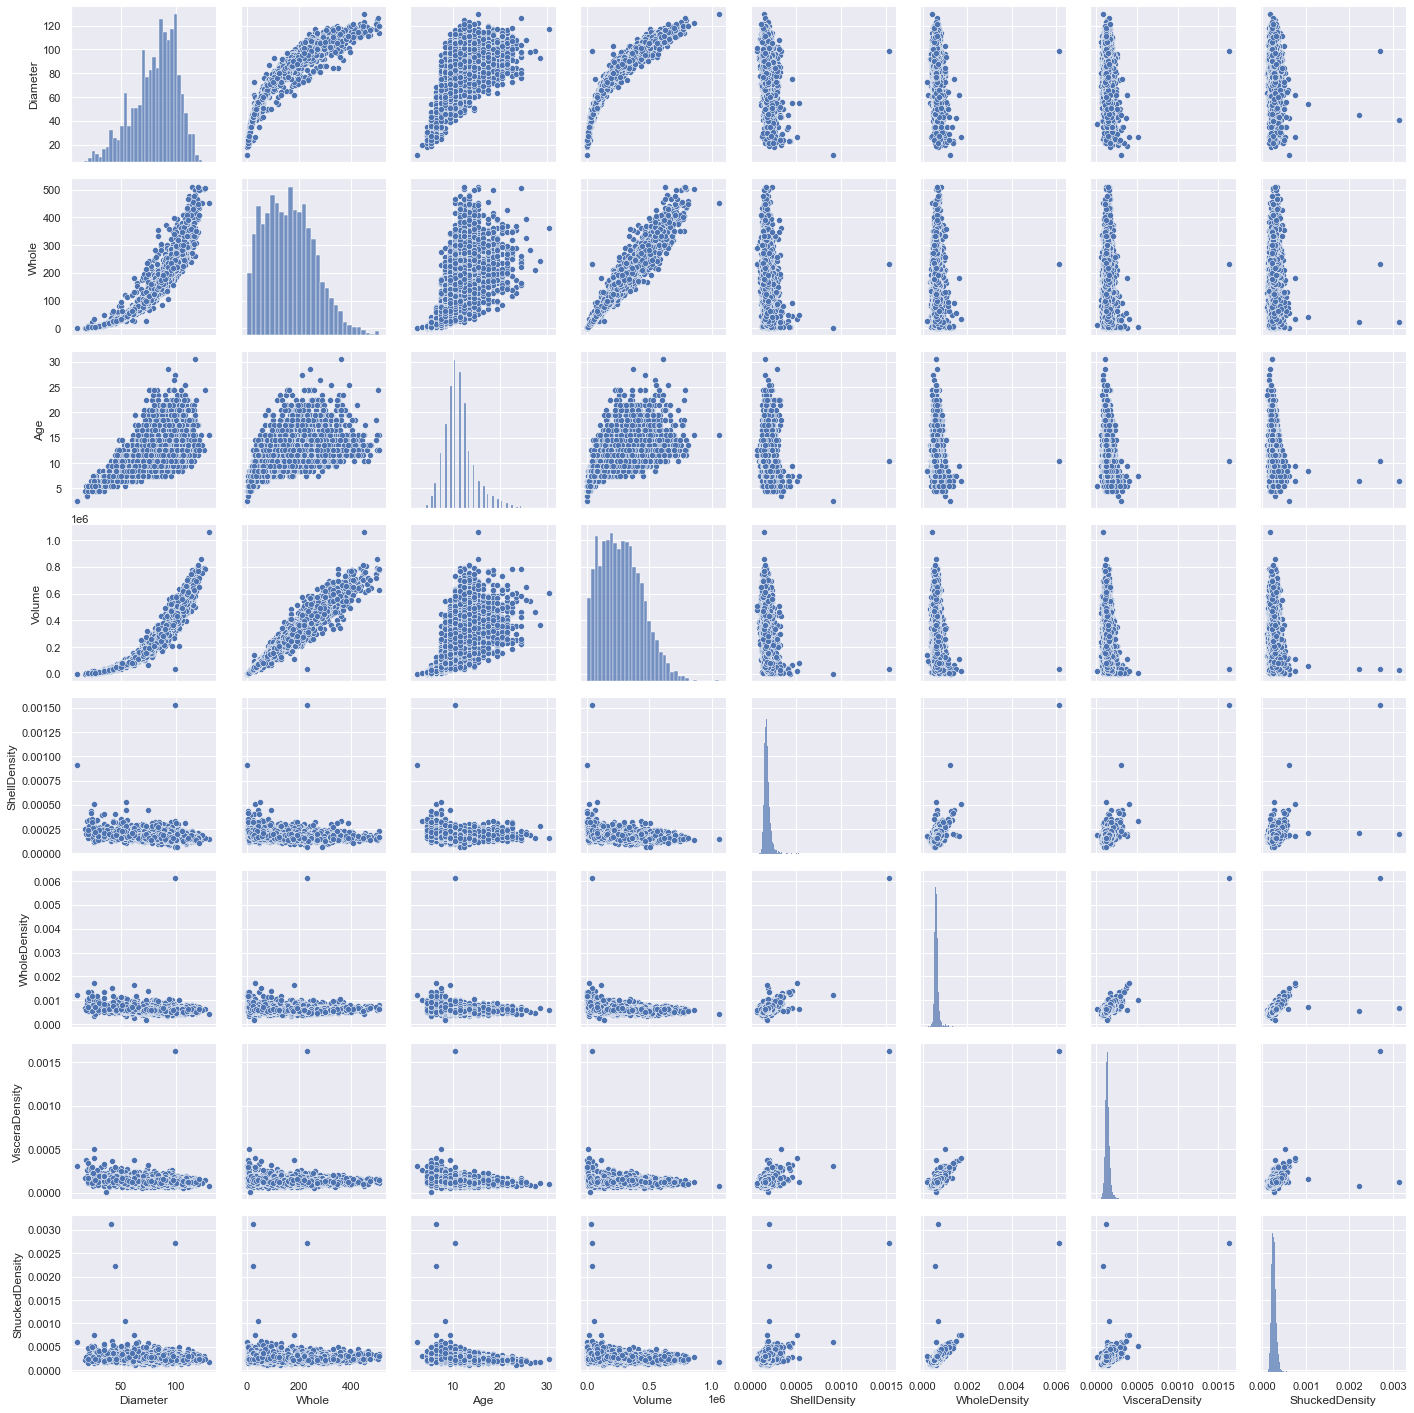

In [10]:
df_look = df.copy()

df_look.drop(["Sex", "IsFemale", "IsMale","Length", "Height", "Shucked", "Viscera", "Shell", "Rings"], axis=1, inplace=True)
print(df_look)
sns.set()
sns.pairplot(df_look)
plt.show();

Видны выбросы плотности. Удаляем, повторяем.

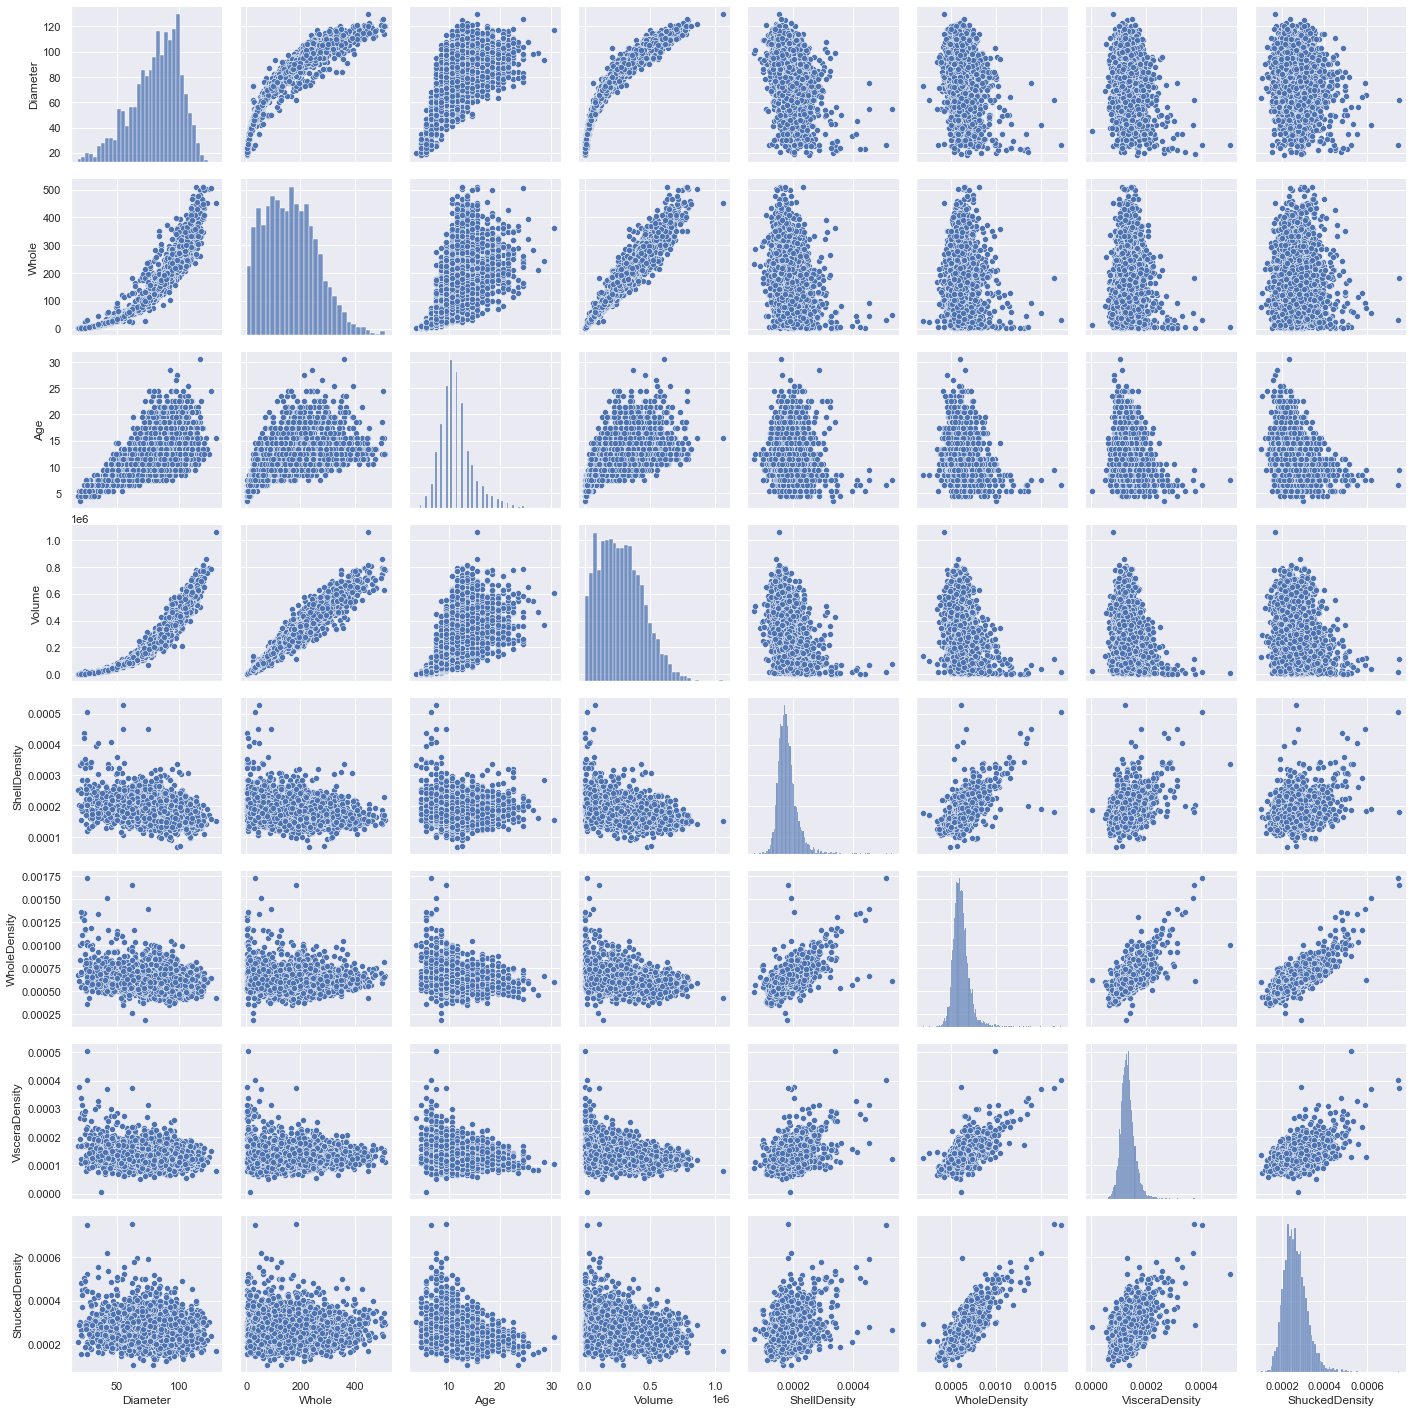

<AxesSubplot:>

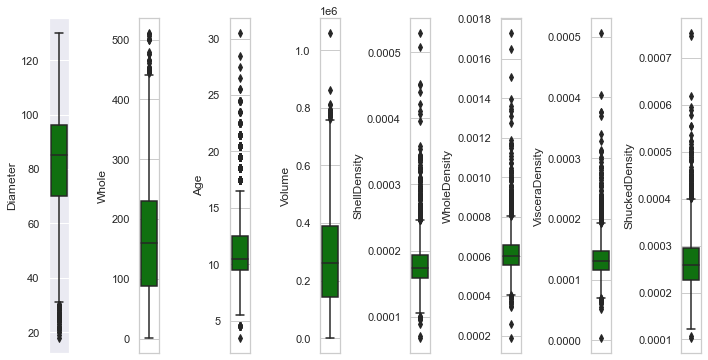

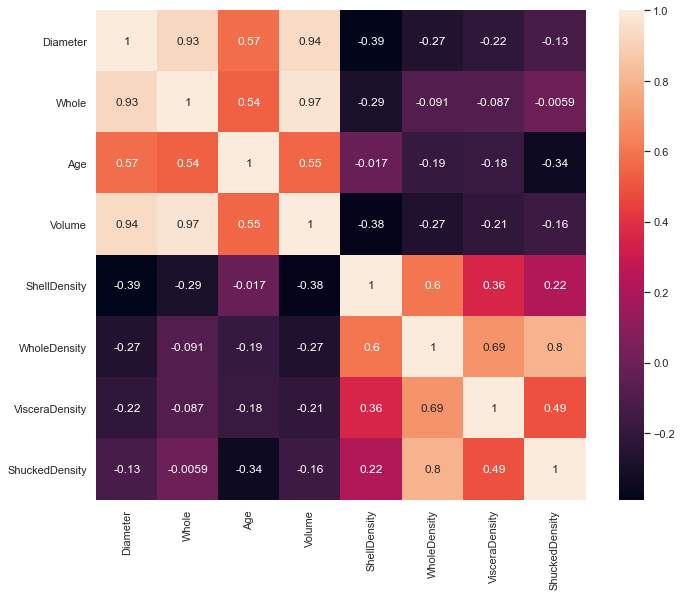

In [11]:
df.drop(df[df["ShellDensity"] > 0.00075].index, axis=0, inplace=True)
df.drop(df[df["WholeDensity"] > 0.0025].index, axis=0, inplace=True)
df.drop(df[df["VisceraDensity"] > 0.001].index, axis=0, inplace=True)
df.drop(df[df["ShuckedDensity"] > 0.001].index, axis=0, inplace=True)

df_look = df.copy()

df_look.drop(["Sex", "IsFemale", "IsMale","Length", "Height", "Shucked", "Viscera", "Shell", "Rings"], axis=1, inplace=True)

sns.set()
sns.pairplot(df_look)
plt.show();

l = df_look.loc[:, 'Diameter':].columns.values
number_of_columns = len(l)
number_of_rows = 1
plt.figure(figsize=(10,10))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1, number_of_columns,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(y=df_look[l[i]],color='green',orient='v')
    plt.tight_layout()
    
corrmat = df_look.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, square=True, annot=True)

Выводы, которые можно сделать по этим диаграммам:
 * Вес почти линейно зависит от объёма (логично)
 * Плотность разных ушек в целом очень близка, но не совсем одинаковая; для маленьких ушек разброс плотности больше, чем для больших. Возможно, это связано с большей относительной ошибкой при измерениях при неизменной абсолютной ошибке.
 
 

Исходя из этого, было решено сделать несколько датасетов с разными параметрами. Наиболее важные параметры:
1. Пол - наверно, он должен влиять, хотя он не сильно коррелирует с возрастом
2. Высота - наиболее коррелирующий из размеров
3. Вес ракушки - наиболее коррелирующий из весов
4. Плотность мяса - как наиболее кореллирующая из плотностей

Естественно, также мы оставим возраст, т.к. его надо предсказать. Не забываем, что пол мы кодировали через one-hot encoding.

Также в одном датасете можно оставить все признаки (удалим только количество колей и пол, т.к. они есть в других признаках) и посмотреть, какие мы получим результаты.

In [12]:
df.columns

Index(['Sex', 'Length', 'Diameter', 'Height', 'Whole', 'Shucked', 'Viscera',
       'Shell', 'Rings', 'IsMale', 'IsFemale', 'Age', 'Volume', 'ShellDensity',
       'WholeDensity', 'VisceraDensity', 'ShuckedDensity'],
      dtype='object')

In [13]:
clean_df_0 = df[['Length', 'Diameter', 'Height', 'Whole', 'Shucked', 'Viscera',
       'Shell', 'IsMale', 'IsFemale', 'Volume', 'ShellDensity',
       'WholeDensity', 'VisceraDensity', 'ShuckedDensity', 'Age']].copy()
clean_df_1 = df[['Height', 'Shell', 'IsMale', 'IsFemale', 'Age']].copy()
clean_df_2 = df[['Height', 'Shell', 'ShuckedDensity', 'IsMale', 'IsFemale', 'Age']].copy()
clean_df_3 = df[['Height', 'ShuckedDensity', 'IsMale', 'IsFemale', 'Age']].copy()
clean_df_4 = df[['Height', 'IsMale', 'IsFemale', 'Age']].copy()
clean_df_5 = df[['Height', 'Age']].copy()

clean_dfs = [clean_df_0, clean_df_1, clean_df_2, clean_df_3, clean_df_4, clean_df_5]

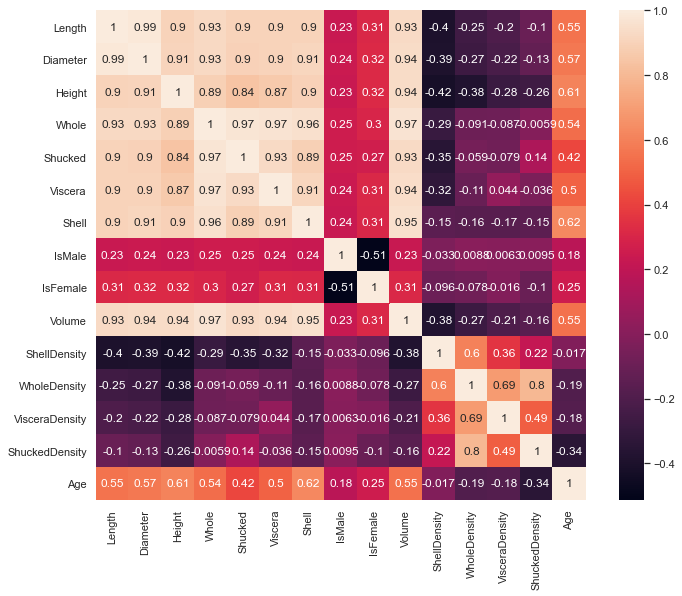

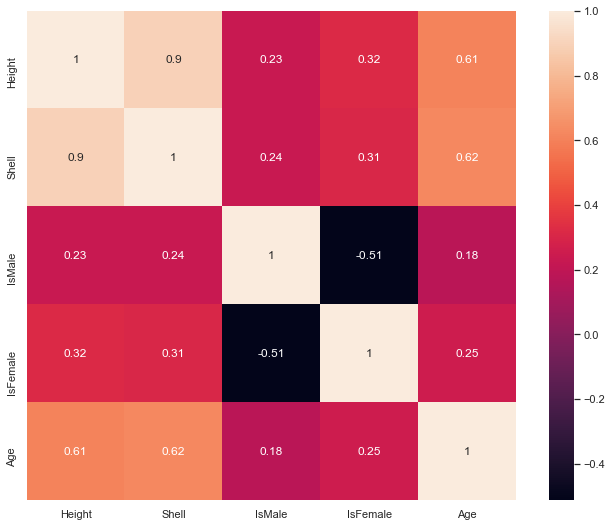

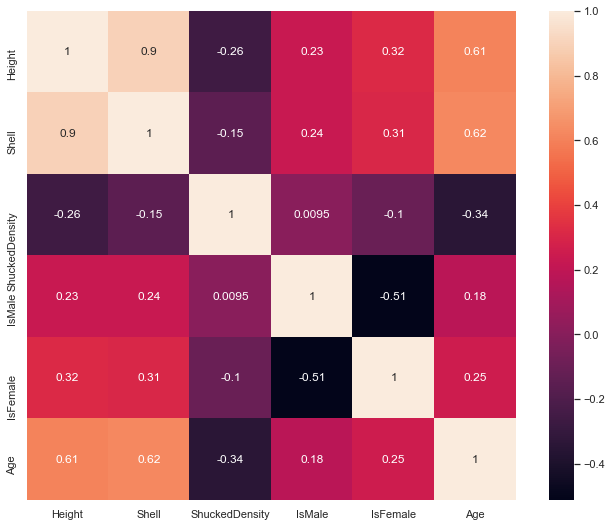

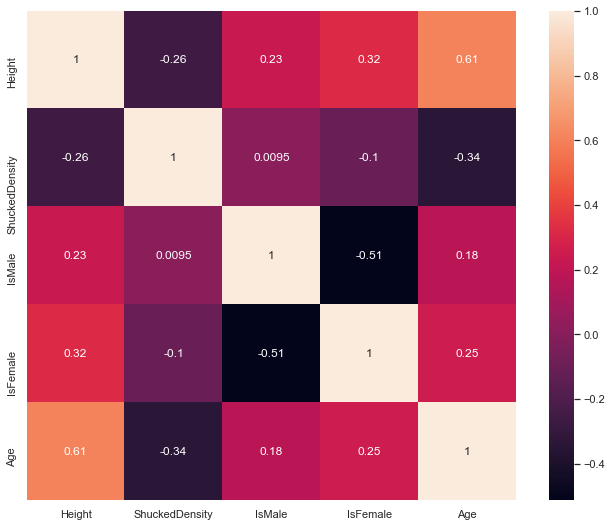

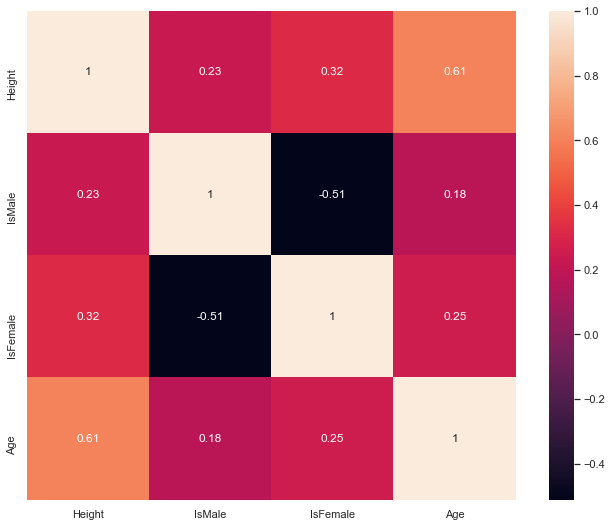

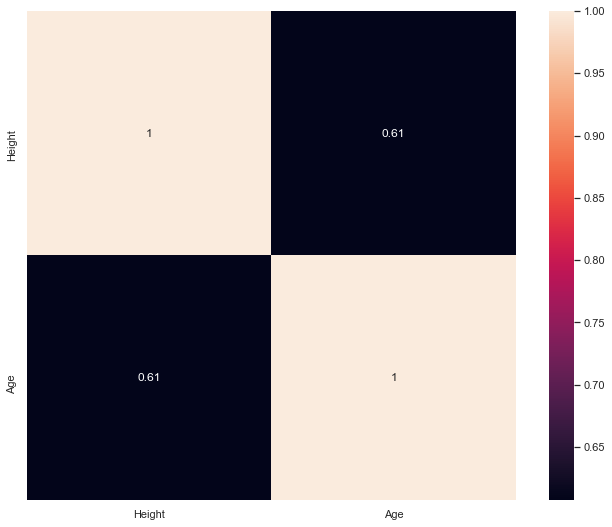

In [14]:
for clean_df in clean_dfs:
    corrmat = clean_df.corr()
    f, ax = plt.subplots(figsize=(12, 9))
    sns.heatmap(corrmat, square=True, annot=True)

Нормализуем.

In [15]:
import sklearn

from sklearn.preprocessing import MinMaxScaler

In [16]:
for clean_df in clean_dfs:
    scaler = MinMaxScaler()
    clean_df = clean_dfs[0]
    y = clean_df['Age']
    clean_df.drop('Age', axis=1, inplace=True)
    columns = clean_df.columns
    clean_df[columns] = scaler.fit_transform(clean_df[columns])
    clean_df['Age'] = y

In [17]:
clean_dfs[0].describe()

,Length,Diameter,Height,Whole,Shucked,Viscera,Shell,IsMale,IsFemale,Volume,ShellDensity,WholeDensity,VisceraDensity,ShuckedDensity,Age
count,4158.000000,4158.000000,4158.000000,4158.000000,4158.000000,4158.000000,4158.000000,4158.000000,4158.000000,4158.000000,4158.000000,4158.000000,4158.000000,4158.000000,4158.000000
mean,0.586930,0.567293,0.528379,0.321051,0.284125,0.304523,0.295425,0.366041,0.312650,0.259287,0.241236,0.275248,0.257638,0.247196,11.425685
std,0.169502,0.176303,0.162032,0.190195,0.175349,0.183997,0.171968,0.481779,0.463629,0.156307,0.072806,0.063573,0.058718,0.088213,3.202568
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.500000
25%,0.482270,0.464286,0.425532,0.170446,0.146741,0.157761,0.159849,0.000000,0.000000,0.133629,0.195363,0.237716,0.222191,0.187884,9.500000
50%,0.617021,0.598214,0.531915,0.310660,0.266293,0.288380,0.289490,0.000000,0.000000,0.246097,0.229757,0.267831,0.251445,0.237734,10.500000
75%,0.716312,0.696429,0.638298,0.448371,0.398241,0.426633,0.407017,1.000000,1.000000,0.365663,0.271674,0.302428,0.283685,0.294727,12.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,30.500000


Как видно, всё нормализовалось, теперь прогоняем по разным моделям.

Для подбора модели воспользуемся методом с scikit-learn: переберём кучу моделей на кросс-валидации на тренировочных данных, отберём несколько лучших, из них выберем самую лучшую с помощью тестовых данных.

https://scikit-learn.org/stable/modules/model_evaluation.html

<div>
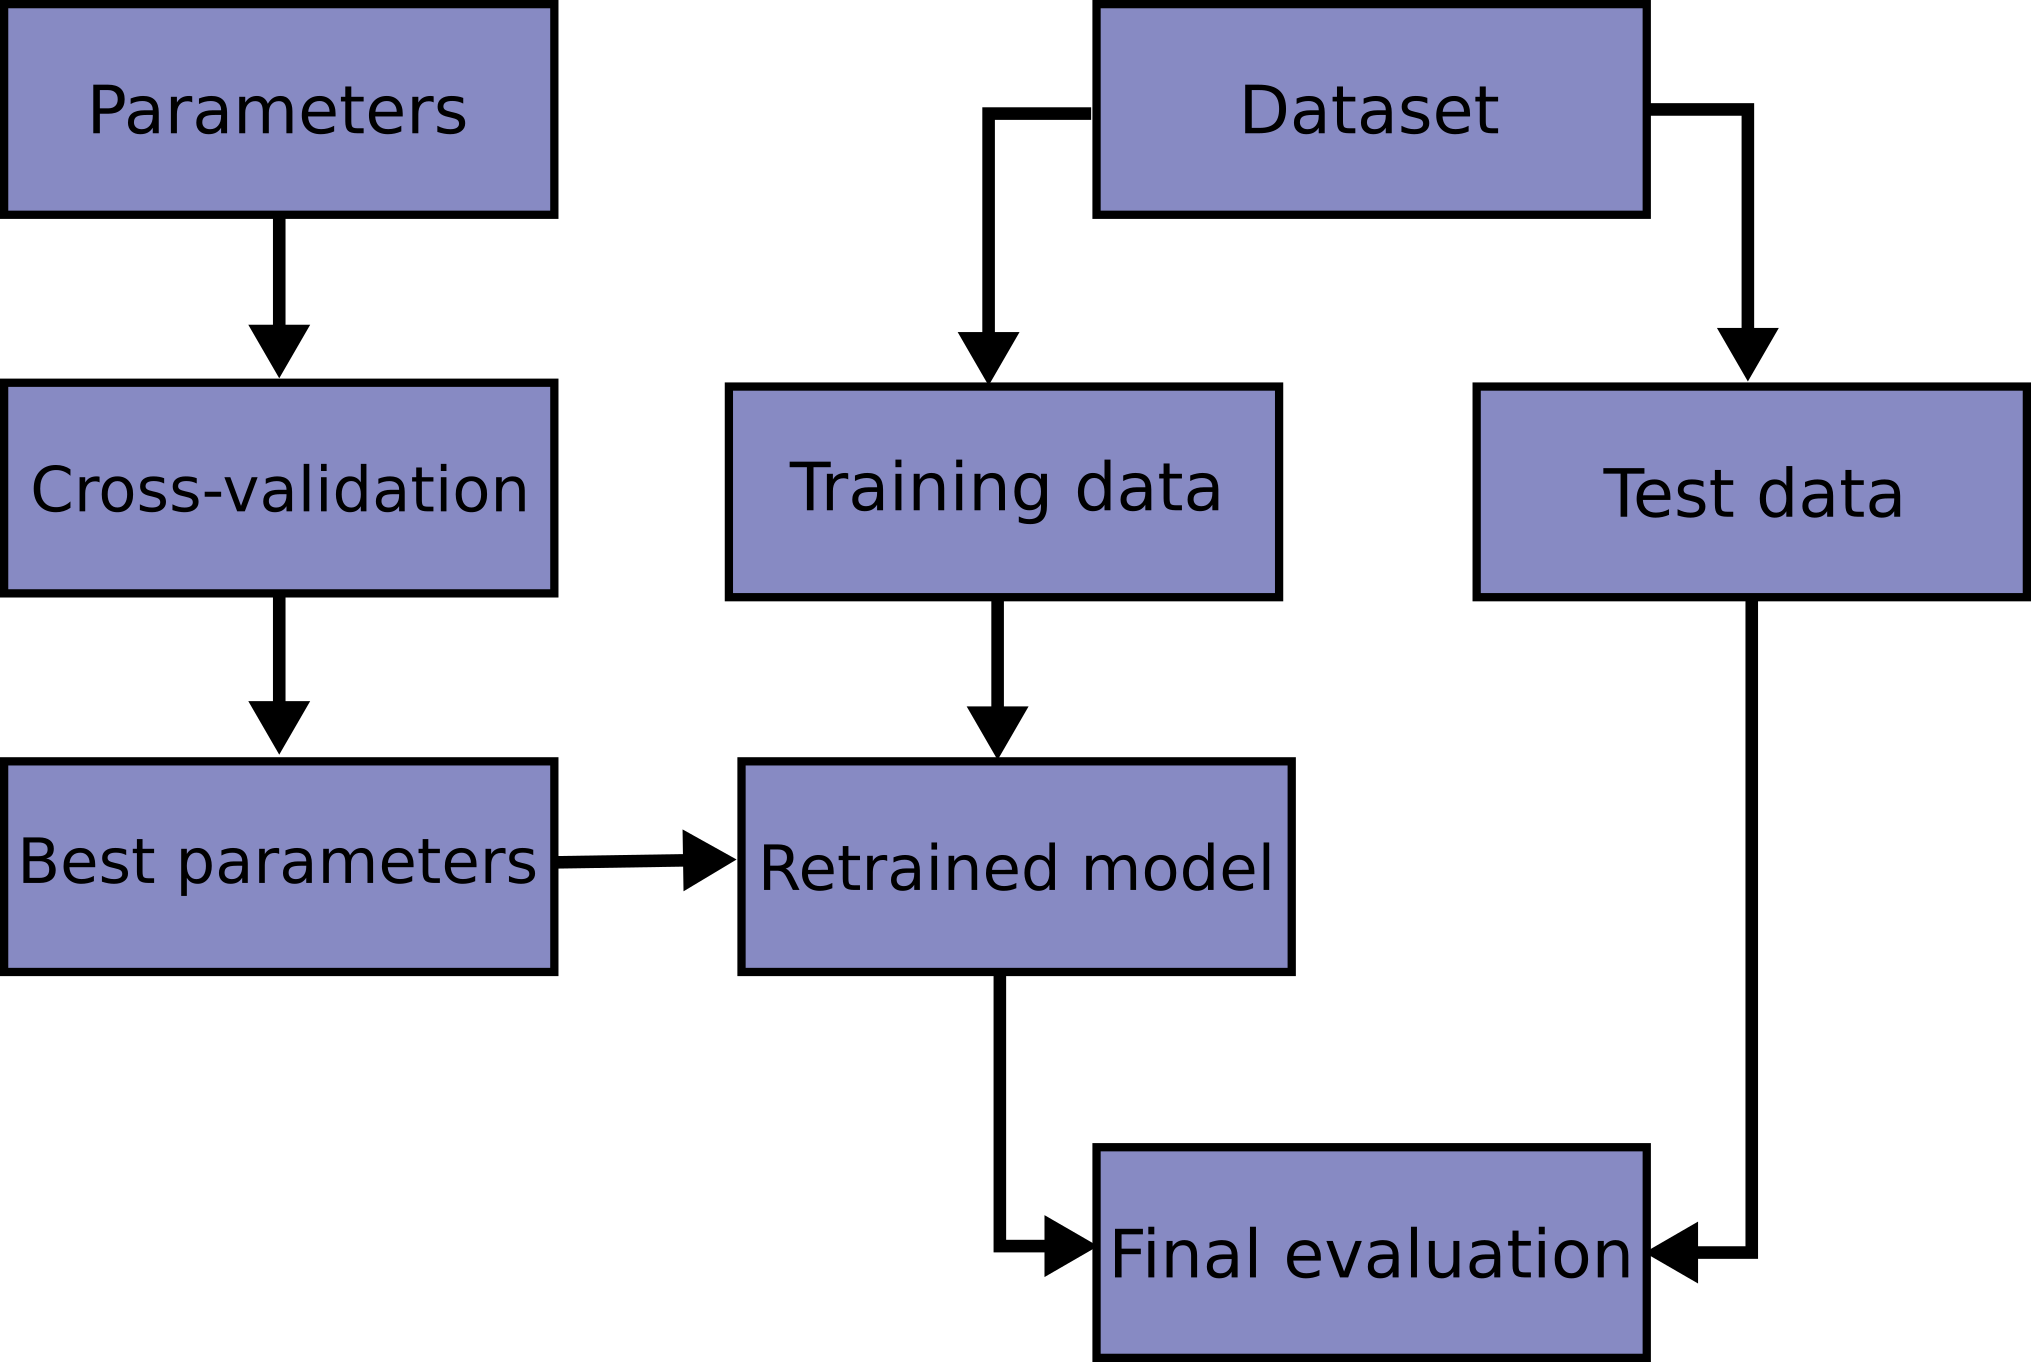
</div>

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC, SVR, LinearSVR, NuSVR
from sklearn.metrics import *
from sklearn.tree import *
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import *
from sklearn.model_selection import cross_validate

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

from pprint import pprint

In [19]:
def split_data(df):
    X_data, Y_data = df.loc[:,:], df["Age"]
    X_data = X_data.drop(['Age'], axis=1, inplace=False)
    X_train,  X_test,  y_train,  y_test =  train_test_split(X_data, Y_data,  test_size= 0.20,  random_state= 42 )
    splitted_data = [X_train, y_train]
    test_splitted_data = [X_test, y_test]
    # данные, дополненные полиномами
    poly = PolynomialFeatures(degree = 2)
    poly_splitted_data = [poly.fit_transform(X_train), y_train]
    test_poly_splitted_data = [poly.transform(X_test), y_test]
    return splitted_data, test_splitted_data, poly_splitted_data, test_poly_splitted_data

Обратите внимание, что в cross_validate функции оценки следуют правилу «больше = лучше», поэтому некоторые из них берутся со знаком минус — это касается и используемого в данной работе корня из среднеквадратической ошибки.

In [20]:
def test_model(train_X, train_y, model, params=[{}], sep='',
 show_params=True, print_errors=True, save_model=True, preprint_message = ''):
    res = []
    for param in params:
        if preprint_message!='':
            print(preprint_message)
        if params != [{}] and show_params:
            print("Параметры:", param)
        if print_errors:
            model_to_test = model(**param)
            crossvalres = cross_validate(model_to_test, train_X, train_y, scoring='neg_mean_absolute_error')
            pprint(crossvalres)
            print(end=sep)
        avg_error = np.average(crossvalres['test_score'])
        res.append(avg_error)
        print("Средняя ошибка: ", avg_error)
    return res

In [21]:
data = [split_data(clean_df) for clean_df in clean_dfs]

Сначала попробуем регрессию и её вариации.

In [22]:
for splitted_data, _, poly_splitted_data, _ in data:
    print(splitted_data[0].columns)
    
    errors = test_model(*splitted_data, LinearRegression, params=[{'normalize':False}], preprint_message = 'LinearRegression')
    min_error = max(errors)
    
    errors = test_model(*poly_splitted_data, LinearRegression, params=[{'normalize':False}], preprint_message = 'LinearRegression_poly')
    min_error = max(max(errors),min_error)
          
    errors = test_model(*splitted_data, SVR, params=[
        {'kernel': 'linear', 'gamma':'auto', 'max_iter':1000000}, 
        {'kernel': 'poly', 'degree': 2, 'gamma':'auto', 'max_iter':1000000}, 
        {'kernel': 'rbf', 'gamma':'auto', 'max_iter':1000000},
        {'kernel': 'linear', 'gamma':'scale', 'max_iter':1000000}, 
        {'kernel': 'poly', 'degree': 2, 'gamma':'scale', 'max_iter':1000000}, 
        {'kernel': 'rbf', 'gamma':'scale', 'max_iter':1000000},
    ], preprint_message = 'SVR')
    min_error = max(max(errors),min_error)
    
    params = [
        {'C':1.0, 'max_iter':10000}, 
        {'C':2.5, 'max_iter':100000}, 
        {'C':5.0, 'max_iter':100000}, 
        {'C':7.5, 'max_iter':100000}, 
        {'C':10.0, 'max_iter':100000}, 
        {'C':25.0, 'max_iter':10000000},
        {'C':50.0, 'max_iter':10000000},
    ]
    errors = test_model(*splitted_data, LinearSVR, params=params, preprint_message = 'LinearSVR')
    min_error = max(max(errors),min_error)

    params = [{'nu':x, 'gamma':'auto'} for x in [.01,.1,.2,.3,.4,.5,.6,.8,1.0]]
    errors = test_model(*splitted_data, NuSVR, params=params, preprint_message = 'NuSVR')
    min_error = max(max(errors),min_error)

    params = [{"max_depth":x} for x in range(1,10)]
    errors = test_model(*splitted_data, DecisionTreeRegressor, params, preprint_message = 'DecisionTreeRegressor')
    min_error = max(max(errors),min_error)
    
    params = [{'n_neighbors':x} for x in (3,4,5,6,7,8,9,10)]
    errors = test_model(*splitted_data, KNeighborsRegressor, params = params, preprint_message = 'KNeighborsRegressor')
    min_error = max(max(errors),min_error)
    
    params = [{'alpha':x} for x in (0.001, 0.01, 0.1, 1.0, 10.0)]
    errors = test_model(*splitted_data, KernelRidge, params = params, preprint_message = 'KernelRidge')
    min_error = max(max(errors),min_error)
    print("\n\n\n**********************\n")
    print("Min error: ", -min_error)
    print("\n**********************\n\n\n")

Index(['Length', 'Diameter', 'Height', 'Whole', 'Shucked', 'Viscera', 'Shell',
       'IsMale', 'IsFemale', 'Volume', 'ShellDensity', 'WholeDensity',
       'VisceraDensity', 'ShuckedDensity'],
      dtype='object')
LinearRegression
Параметры: {'normalize': False}
{'fit_time': array([0.00500107, 0.00300121, 0.00400066, 0.00300121, 0.00300097]),
 'score_time': array([0.00300097, 0.00200033, 0.00100064, 0.00299978, 0.00200081]),
 'test_score': array([-1.55353023, -1.55661232, -1.54294746, -1.48009633, -1.45450522])}
Средняя ошибка:  -1.5175383126566568
LinearRegression_poly
Параметры: {'normalize': False}
{'fit_time': array([0.03600812, 0.03600812, 0.03700829, 0.03400731, 0.03700852]),
 'score_time': array([0.00099969, 0.        , 0.        , 0.0010004 , 0.        ]),
 'test_score': array([-1.56139973, -1.54245771, -1.52410182, -1.49099898, -1.50011763])}
Средняя ошибка:  -1.5238151740260708
SVR
Параметры: {'kernel': 'linear', 'gamma': 'auto', 'max_iter': 1000000}
{'fit_time': array([0.2

{'fit_time': array([0.32707381, 0.33807683, 0.31357837, 0.31307101, 0.32907486]),
 'score_time': array([0.04501009, 0.04501033, 0.0470109 , 0.05301166, 0.0400095 ]),
 'test_score': array([-1.60526705, -1.59498916, -1.61843231, -1.61837239, -1.45228188])}
Средняя ошибка:  -1.5778685560293175
DecisionTreeRegressor
Параметры: {'max_depth': 1}
{'fit_time': array([0.00500083, 0.00400019, 0.00500083, 0.00500178, 0.0070014 ]),
 'score_time': array([0.00200033, 0.00200057, 0.00300026, 0.00199986, 0.00200033]),
 'test_score': array([-1.95484543, -2.05928205, -2.00332462, -1.93505664, -1.84048445])}
Средняя ошибка:  -1.9585986383313485
DecisionTreeRegressor
Параметры: {'max_depth': 2}
{'fit_time': array([0.00800085, 0.00800157, 0.00900149, 0.00700164, 0.00600195]),
 'score_time': array([0.00200152, 0.00300121, 0.00200033, 0.00100017, 0.00200081]),
 'test_score': array([-1.84321953, -1.875476  , -1.82118768, -1.84932584, -1.66578873])}
Средняя ошибка:  -1.8109995553942748
DecisionTreeRegressor
Па

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processin

{'fit_time': array([4.13295174, 4.60254931, 4.61755323, 4.43801951, 4.35800314]),
 'score_time': array([0.00900197, 0.00900197, 0.00900173, 0.01000214, 0.01000214]),
 'test_score': array([-1.72200515, -1.71367567, -1.73260332, -1.71934307, -1.58630207])}
Средняя ошибка:  -1.6947858574304147
SVR
Параметры: {'kernel': 'poly', 'degree': 2, 'gamma': 'auto', 'max_iter': 1000000}


c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processin

{'fit_time': array([32.365376  , 33.97775769, 33.82377458, 35.49908638, 34.3913424 ]),
 'score_time': array([0.01400304, 0.01300311, 0.01300311, 0.0130024 , 0.01300263]),
 'test_score': array([-11.96480729,  -6.72918643, -12.94241145,  -9.25285142,
        -4.38784173])}
Средняя ошибка:  -9.055419663123505
SVR
Параметры: {'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 1000000}
{'fit_time': array([0.36508203, 0.33907628, 0.35207963, 0.33258319, 0.33507586]),
 'score_time': array([0.06101489, 0.04501057, 0.05201221, 0.04501033, 0.04000926]),
 'test_score': array([-1.74410462, -1.72259606, -1.79322443, -1.75137731, -1.58049495])}
Средняя ошибка:  -1.718359472832536
SVR
Параметры: {'kernel': 'linear', 'gamma': 'scale', 'max_iter': 1000000}


c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processin

{'fit_time': array([4.13493729, 4.832093  , 4.5675416 , 4.3584938 , 4.3719902 ]),
 'score_time': array([0.00800157, 0.00900197, 0.00900197, 0.00900221, 0.00900173]),
 'test_score': array([-1.72200515, -1.71367567, -1.73260332, -1.71934307, -1.58630207])}
Средняя ошибка:  -1.6947858574304147
SVR
Параметры: {'kernel': 'poly', 'degree': 2, 'gamma': 'scale', 'max_iter': 1000000}
{'fit_time': array([0.23905373, 0.21605039, 0.29506683, 0.21904874, 0.22805142]),
 'score_time': array([0.01500297, 0.01600266, 0.01400375, 0.01300359, 0.01300335]),
 'test_score': array([-1.7902649 , -1.76145501, -1.79338362, -1.80718456, -1.68115451])}
Средняя ошибка:  -1.7666885226912612
SVR
Параметры: {'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 1000000}
{'fit_time': array([0.22705078, 0.25605798, 0.24205494, 0.26305962, 0.26606011]),
 'score_time': array([0.04000974, 0.02500558, 0.03500748, 0.02400517, 0.03200746]),
 'test_score': array([-1.6894262 , -1.67823702, -1.72367038, -1.68643896, -1.55548842])}
Сре

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packag

{'fit_time': array([0.67615414, 0.70816064, 0.66214943, 0.64514661, 0.70615959]),
 'score_time': array([0.00199962, 0.00200033, 0.00200057, 0.00200033, 0.00200057]),
 'test_score': array([-1.73498691, -1.7030116 , -1.77127196, -1.70074351, -1.58889942])}
Средняя ошибка:  -1.699782679471129
LinearSVR
Параметры: {'C': 2.5, 'max_iter': 100000}


c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packag

{'fit_time': array([3.09670067, 3.17972016, 2.96867228, 3.00067997, 3.13472438]),
 'score_time': array([0.00200057, 0.00200057, 0.00200057, 0.00200009, 0.00200057]),
 'test_score': array([-1.71036379, -1.7031533 , -1.73165914, -1.70595166, -1.58548214])}
Средняя ошибка:  -1.6873220062914314
LinearSVR
Параметры: {'C': 5.0, 'max_iter': 100000}


c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packag

{'fit_time': array([4.63404918, 5.14017892, 4.69307923, 4.72206903, 4.72807074]),
 'score_time': array([0.00100017, 0.00200081, 0.00200081, 0.00200033, 0.00200009]),
 'test_score': array([-1.71045694, -1.70161761, -1.74086952, -1.74897438, -1.6016265 ])}
Средняя ошибка:  -1.7007089906127675
LinearSVR
Параметры: {'C': 7.5, 'max_iter': 100000}


c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packag

{'fit_time': array([5.8853333 , 6.10039783, 5.83337498, 4.98363519, 5.42175055]),
 'score_time': array([0.00300074, 0.00200033, 0.00200081, 0.00200057, 0.00200009]),
 'test_score': array([-1.71893268, -1.70129508, -1.73076847, -1.71913094, -1.58318682])}
Средняя ошибка:  -1.690662798870609
LinearSVR
Параметры: {'C': 10.0, 'max_iter': 100000}


c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packag

{'fit_time': array([6.03988886, 5.85786724, 5.76439714, 5.88383865, 5.84384656]),
 'score_time': array([0.00200081, 0.00200033, 0.00200033, 0.00200033, 0.00200057]),
 'test_score': array([-1.7439926 , -1.70367165, -1.72893095, -1.69863068, -1.58797829])}
Средняя ошибка:  -1.6926408367371224
LinearSVR
Параметры: {'C': 25.0, 'max_iter': 10000000}
{'fit_time': array([34.86851931, 31.42383456, 34.59693551, 36.29935908, 34.82996345]),
 'score_time': array([0.00200081, 0.00200105, 0.00200057, 0.00200152, 0.00200033]),
 'test_score': array([-1.71414298, -1.71231182, -1.7296583 , -1.71200442, -1.58569823])}
Средняя ошибка:  -1.6907631489751256
LinearSVR
Параметры: {'C': 50.0, 'max_iter': 10000000}
{'fit_time': array([74.58965111, 70.87571859, 70.70274329, 71.67692327, 67.72242808]),
 'score_time': array([0.00200009, 0.00200081, 0.00200057, 0.00300097, 0.00200057]),
 'test_score': array([-1.71152799, -1.71450033, -1.72965256, -1.7121303 , -1.58559695])}
Средняя ошибка:  -1.6906816245022231
NuSV

 'test_score': array([-1.90165165, -1.85538847, -1.8556391 , -1.7962406 , -1.69498747])}
Средняя ошибка:  -1.8207814581498791
KNeighborsRegressor
Параметры: {'n_neighbors': 7}
{'fit_time': array([0.00700116, 0.00700164, 0.00800133, 0.0070014 , 0.00500107]),
 'score_time': array([0.00700212, 0.00700164, 0.00600171, 0.00500107, 0.00400138]),
 'test_score': array([-1.86186186, -1.84081633, -1.84425349, -1.80408163, -1.68721805])}
Средняя ошибка:  -1.80764627140567
KNeighborsRegressor
Параметры: {'n_neighbors': 8}
{'fit_time': array([0.00600171, 0.00500154, 0.00500083, 0.00500035, 0.0040009 ]),
 'score_time': array([0.00400043, 0.00400114, 0.00400186, 0.00400114, 0.00500107]),
 'test_score': array([-1.85604354, -1.83590226, -1.82744361, -1.79530075, -1.68082707])}
Средняя ошибка:  -1.799103445550814
KNeighborsRegressor
Параметры: {'n_neighbors': 9}
{'fit_time': array([0.00400066, 0.00500178, 0.00500107, 0.00800061, 0.00800204]),
 'score_time': array([0.00500083, 0.00400066, 0.00400209, 0.0

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processin

{'fit_time': array([4.49601793, 4.9006536 , 4.93311644, 4.33698201, 4.17145348]),
 'score_time': array([0.0100019 , 0.01300287, 0.01100254, 0.01200342, 0.01500368]),
 'test_score': array([-1.72340148, -1.71952977, -1.73115101, -1.70084349, -1.5863703 ])}
Средняя ошибка:  -1.692259208425201
SVR
Параметры: {'kernel': 'poly', 'degree': 2, 'gamma': 'auto', 'max_iter': 1000000}


c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processin

{'fit_time': array([34.91846299, 33.95473456, 36.11879778, 34.72055054, 36.61686945]),
 'score_time': array([0.01500368, 0.01400352, 0.01400328, 0.01400328, 0.0150032 ]),
 'test_score': array([-10.04427211,  -8.25304842,  -2.65886844, -17.20953871,
        -3.17873555])}
Средняя ошибка:  -8.268892645360475
SVR
Параметры: {'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 1000000}
{'fit_time': array([0.32107282, 0.30708528, 0.3300755 , 0.32507396, 0.31007028]),
 'score_time': array([0.04501009, 0.03800845, 0.04100823, 0.04601073, 0.03900838]),
 'test_score': array([-1.7291412 , -1.71595558, -1.77984511, -1.73535192, -1.56817676])}
Средняя ошибка:  -1.7056941148407518
SVR
Параметры: {'kernel': 'linear', 'gamma': 'scale', 'max_iter': 1000000}


c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processin

{'fit_time': array([4.41350722, 4.81208968, 4.70359755, 4.1604495 , 4.14244556]),
 'score_time': array([0.01000214, 0.01000237, 0.01000237, 0.01000261, 0.01000237]),
 'test_score': array([-1.72340148, -1.71952977, -1.73115101, -1.70084349, -1.5863703 ])}
Средняя ошибка:  -1.692259208425201
SVR
Параметры: {'kernel': 'poly', 'degree': 2, 'gamma': 'scale', 'max_iter': 1000000}
{'fit_time': array([0.24456549, 0.23205233, 0.22455883, 0.23605371, 0.23505306]),
 'score_time': array([0.01500392, 0.01500344, 0.01400352, 0.01400304, 0.01500344]),
 'test_score': array([-1.79060658, -1.7611652 , -1.79366524, -1.80657435, -1.68120591])}
Средняя ошибка:  -1.7666434581863233
SVR
Параметры: {'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 1000000}
{'fit_time': array([0.2140491 , 0.27706242, 0.21604872, 0.2740624 , 0.2365613 ]),
 'score_time': array([0.03100705, 0.03800797, 0.02800632, 0.03300762, 0.03600836]),
 'test_score': array([-1.69017547, -1.67889459, -1.72379441, -1.68608897, -1.55592135])}
Сред

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packag

{'fit_time': array([0.7176919 , 0.73716617, 0.71216178, 0.7451694 , 0.70515871]),
 'score_time': array([0.00200129, 0.00200009, 0.00300097, 0.00200009, 0.00200033]),
 'test_score': array([-1.72609351, -1.7129621 , -1.72960397, -1.71537467, -1.61760907])}
Средняя ошибка:  -1.7003286652255938
LinearSVR
Параметры: {'C': 2.5, 'max_iter': 100000}


c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packag

{'fit_time': array([3.43130016, 3.37176394, 3.25873828, 3.22272992, 3.25175214]),
 'score_time': array([0.00200009, 0.00199986, 0.00100017, 0.00200105, 0.00200033]),
 'test_score': array([-1.71034257, -1.7115847 , -1.72924002, -1.72053348, -1.58615649])}
Средняя ошибка:  -1.6915714512811768
LinearSVR
Параметры: {'C': 5.0, 'max_iter': 100000}


c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packag

{'fit_time': array([4.85063744, 5.07565546, 5.23069119, 5.31822157, 4.82709265]),
 'score_time': array([0.00200009, 0.00200105, 0.00200009, 0.00200057, 0.00300097]),
 'test_score': array([-1.71748658, -1.70410781, -1.7356927 , -1.7025324 , -1.5998523 ])}
Средняя ошибка:  -1.6919343568755454
LinearSVR
Параметры: {'C': 7.5, 'max_iter': 100000}


c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packag

{'fit_time': array([6.23391986, 6.08988667, 6.33345151, 6.20143247, 5.91635466]),
 'score_time': array([0.00200152, 0.00300145, 0.00200081, 0.00200057, 0.00200057]),
 'test_score': array([-1.72817184, -1.70488969, -1.73298713, -1.71612561, -1.61400756])}
Средняя ошибка:  -1.6992363668562416
LinearSVR
Параметры: {'C': 10.0, 'max_iter': 100000}


c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packag

{'fit_time': array([6.36147666, 5.93690777, 5.88290477, 6.1264236 , 6.22841096]),
 'score_time': array([0.00200033, 0.00200033, 0.00200057, 0.00200033, 0.00200105]),
 'test_score': array([-1.74112424, -1.73145909, -1.73314147, -1.71082491, -1.58786883])}
Средняя ошибка:  -1.7008837074749255
LinearSVR
Параметры: {'C': 25.0, 'max_iter': 10000000}
{'fit_time': array([35.77624035, 33.90057945, 35.81119657, 36.41140938, 34.04581642]),
 'score_time': array([0.00200105, 0.00299931, 0.00300074, 0.00200152, 0.00200081]),
 'test_score': array([-1.71169391, -1.71336558, -1.72995987, -1.71109226, -1.58580394])}
Средняя ошибка:  -1.6903831135361211
LinearSVR
Параметры: {'C': 50.0, 'max_iter': 10000000}
{'fit_time': array([71.3299551 , 65.51800466, 71.17333794, 72.39958978, 68.70375061]),
 'score_time': array([0.00199938, 0.00199938, 0.00200081, 0.00200081, 0.00200057]),
 'test_score': array([-1.71191361, -1.70852683, -1.72997527, -1.71056709, -1.58534559])}
Средняя ошибка:  -1.6892656784285571
NuSV

{'fit_time': array([0.00600171, 0.00500083, 0.00500083, 0.00500131, 0.00600219]),
 'score_time': array([0.00500131, 0.00400114, 0.00400114, 0.00400138, 0.00600123]),
 'test_score': array([-1.85885886, -1.81546724, -1.83651987, -1.7972073 , -1.66251343])}
Средняя ошибка:  -1.7941133399780018
KNeighborsRegressor
Параметры: {'n_neighbors': 8}
{'fit_time': array([0.006006  , 0.00500083, 0.00500059, 0.00500107, 0.00500178]),
 'score_time': array([0.0049963 , 0.00500154, 0.00500107, 0.00500083, 0.00400138]),
 'test_score': array([-1.84534535, -1.81842105, -1.81353383, -1.77988722, -1.6537594 ])}
Средняя ошибка:  -1.782189369820949
KNeighborsRegressor
Параметры: {'n_neighbors': 9}
{'fit_time': array([0.00600123, 0.00500107, 0.00500107, 0.00700212, 0.00700188]),
 'score_time': array([0.00500059, 0.00500131, 0.00600147, 0.00700068, 0.00500107]),
 'test_score': array([-1.82349016, -1.80451128, -1.81236424, -1.78629908, -1.66349206])}
Средняя ошибка:  -1.7780313646980315
KNeighborsRegressor
Парам

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processin

{'fit_time': array([13.10550618, 13.25152493, 11.15355587, 11.96926618,  9.32714081]),
 'score_time': array([0.01300287, 0.01300359, 0.01200247, 0.01300406, 0.01300287]),
 'test_score': array([-1.76241318, -1.79790078, -1.82854927, -1.80909918, -1.6405526 ])}
Средняя ошибка:  -1.767703000606759
SVR
Параметры: {'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 1000000}
{'fit_time': array([0.24405503, 0.21704936, 0.23856235, 0.23305249, 0.24305463]),
 'score_time': array([0.02400565, 0.02300453, 0.02300501, 0.02600598, 0.02400565]),
 'test_score': array([-1.69232293, -1.71880995, -1.76254343, -1.74662295, -1.54461673])}
Средняя ошибка:  -1.6929831998707054
SVR
Параметры: {'kernel': 'linear', 'gamma': 'scale', 'max_iter': 1000000}
{'fit_time': array([0.66515231, 0.67215347, 0.59213424, 0.57913136, 0.40909338]),
 'score_time': array([0.00999999, 0.01100087, 0.00800133, 0.01600385, 0.00900126]),
 'test_score': array([-1.71230383, -1.73763104, -1.75984918, -1.76015056, -1.58843047])}
Средняя оши

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


{'fit_time': array([0.19404364, 0.23305297, 0.20204616, 0.1830411 , 0.19004345]),
 'score_time': array([0.00200057, 0.00199986, 0.00200057, 0.00200033, 0.00200009]),
 'test_score': array([-1.70903717, -1.74711538, -1.75788126, -1.75483373, -1.58766894])}
Средняя ошибка:  -1.7113072952890225
LinearSVR
Параметры: {'C': 2.5, 'max_iter': 100000}
{'fit_time': array([0.4731071 , 0.5341208 , 0.47510791, 0.50311375, 0.47010469]),
 'score_time': array([0.00200033, 0.0030005 , 0.00300074, 0.00200176, 0.00200129]),
 'test_score': array([-1.70900017, -1.74585752, -1.75705148, -1.7541439 , -1.58269438])}
Средняя ошибка:  -1.7097494903917443
LinearSVR
Параметры: {'C': 5.0, 'max_iter': 100000}
{'fit_time': array([0.88720155, 1.0267601 , 0.96721888, 0.92821002, 0.93071771]),
 'score_time': array([0.00199962, 0.00200057, 0.00200033, 0.00200081, 0.00200081]),
 'test_score': array([-1.70898718, -1.7467616 , -1.75720015, -1.75394017, -1.58269292])}
Средняя ошибка:  -1.7099164043385122
LinearSVR
Параметры:

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


{'fit_time': array([1.34130335, 1.44032574, 1.49833894, 1.3082962 , 1.35330677]),
 'score_time': array([0.00200081, 0.00200081, 0.00300026, 0.00200009, 0.00200057]),
 'test_score': array([-1.70904544, -1.74702105, -1.75709793, -1.75407131, -1.58272159])}
Средняя ошибка:  -1.7099914637722389
LinearSVR
Параметры: {'C': 10.0, 'max_iter': 100000}


c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


{'fit_time': array([1.81140995, 1.82892895, 1.87442493, 1.73239231, 1.77840304]),
 'score_time': array([0.00200105, 0.00199914, 0.00099969, 0.00200057, 0.00200057]),
 'test_score': array([-1.70898662, -1.74476623, -1.75722886, -1.75437117, -1.58336655])}
Средняя ошибка:  -1.7097438860332264
LinearSVR
Параметры: {'C': 25.0, 'max_iter': 10000000}
{'fit_time': array([4.37750077, 4.91412592, 4.42852664, 4.43102074, 4.44900608]),
 'score_time': array([0.00200081, 0.00200033, 0.00300002, 0.00200009, 0.00200081]),
 'test_score': array([-1.7090395 , -1.74675473, -1.76956673, -1.75418555, -1.58301878])}
Средняя ошибка:  -1.7125130584960637
LinearSVR
Параметры: {'C': 50.0, 'max_iter': 10000000}
{'fit_time': array([8.33539462, 9.48465633, 8.7525053 , 8.5264585 , 8.73348594]),
 'score_time': array([0.00300097, 0.00300026, 0.00200105, 0.00200057, 0.00300145]),
 'test_score': array([-1.70898503, -1.74557253, -1.76951281, -1.75400876, -1.58277289])}
Средняя ошибка:  -1.712170403642768
NuSVR
Параметры

{'fit_time': array([0.00500464, 0.00400066, 0.00700212, 0.006001  , 0.0070014 ]),
 'score_time': array([0.00500035, 0.006001  , 0.00700116, 0.0080018 , 0.00500059]),
 'test_score': array([-1.79129129, -1.7693609 , -1.72293233, -1.83026316, -1.63984962])}
Средняя ошибка:  -1.750739461265777
KNeighborsRegressor
Параметры: {'n_neighbors': 9}
{'fit_time': array([0.00500107, 0.00500131, 0.00500154, 0.00500083, 0.00400066]),
 'score_time': array([0.00500107, 0.00500083, 0.00500107, 0.0040009 , 0.00500107]),
 'test_score': array([-1.7659326 , -1.75288221, -1.72163743, -1.80584795, -1.64912281])}
Средняя ошибка:  -1.7390845983828438
KNeighborsRegressor
Параметры: {'n_neighbors': 10}
{'fit_time': array([0.00500059, 0.00500107, 0.00500131, 0.00400066, 0.0040009 ]),
 'score_time': array([0.00500107, 0.00500107, 0.0040009 , 0.00600147, 0.00600171]),
 'test_score': array([-1.76201201, -1.73864662, -1.73609023, -1.80932331, -1.62601504])}
Средняя ошибка:  -1.7344174399963872
KernelRidge
Параметры: {

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processin

{'fit_time': array([14.07521749, 14.81389308, 15.204983  , 15.76909208, 13.14848566]),
 'score_time': array([0.01400208, 0.0140028 , 0.01400137, 0.01600432, 0.01500368]),
 'test_score': array([-1.78330774, -1.78382857, -1.83752263, -1.82497324, -1.64845904])}
Средняя ошибка:  -1.775618242257745
SVR
Параметры: {'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 1000000}
{'fit_time': array([0.2380538 , 0.23105192, 0.23905373, 0.22105026, 0.22004986]),
 'score_time': array([0.02300501, 0.02200532, 0.02200484, 0.02300477, 0.02300596]),
 'test_score': array([-1.69596626, -1.71220525, -1.76267843, -1.74671073, -1.54998745])}
Средняя ошибка:  -1.6935096235358806
SVR
Параметры: {'kernel': 'linear', 'gamma': 'scale', 'max_iter': 1000000}
{'fit_time': array([0.63614297, 0.68515515, 0.73816729, 0.53312111, 0.45010185]),
 'score_time': array([0.01000285, 0.00900221, 0.00900197, 0.00900173, 0.01500344]),
 'test_score': array([-1.71229374, -1.73758124, -1.75983271, -1.76015049, -1.58843459])}
Средняя оши

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


{'fit_time': array([0.17703986, 0.1770401 , 0.21804905, 0.1850419 , 0.17804027]),
 'score_time': array([0.00300074, 0.00200129, 0.00199986, 0.00200081, 0.00300121]),
 'test_score': array([-1.70901925, -1.73757678, -1.75722909, -1.75462357, -1.58878784])}
Средняя ошибка:  -1.7094473047326197
LinearSVR
Параметры: {'C': 2.5, 'max_iter': 100000}
{'fit_time': array([0.48911023, 0.53512168, 0.45810366, 0.47810817, 0.47910833]),
 'score_time': array([0.00300074, 0.00199986, 0.0030005 , 0.00200057, 0.00300097]),
 'test_score': array([-1.70900398, -1.74647226, -1.75707155, -1.75411003, -1.58286678])}
Средняя ошибка:  -1.7099049196264873
LinearSVR
Параметры: {'C': 5.0, 'max_iter': 100000}
{'fit_time': array([0.87870622, 0.97223592, 0.90920591, 0.85219312, 0.91020584]),
 'score_time': array([0.00200009, 0.00200033, 0.00200057, 0.00200033, 0.00200057]),
 'test_score': array([-1.70901497, -1.74584098, -1.75712133, -1.76360038, -1.58288473])}
Средняя ошибка:  -1.7116924786206003
LinearSVR
Параметры:

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


{'fit_time': array([1.27528882, 1.43783307, 1.38682318, 1.33383203, 1.40782666]),
 'score_time': array([0.00200057, 0.0010004 , 0.00199962, 0.00200033, 0.00200057]),
 'test_score': array([-1.70898779, -1.74611832, -1.75709046, -1.75406811, -1.58268757])}
Средняя ошибка:  -1.7097904488892197
LinearSVR
Параметры: {'C': 10.0, 'max_iter': 100000}


c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


{'fit_time': array([1.71740413, 1.69938493, 1.67637968, 1.74090123, 1.667377  ]),
 'score_time': array([0.00200033, 0.00200057, 0.00200057, 0.00200057, 0.00200057]),
 'test_score': array([-1.70900449, -1.74556631, -1.75712954, -1.75425978, -1.58302614])}
Средняя ошибка:  -1.7097972526858332
LinearSVR
Параметры: {'C': 25.0, 'max_iter': 10000000}
{'fit_time': array([4.12446046, 4.63155556, 4.29298544, 4.34698415, 4.21546292]),
 'score_time': array([0.00099993, 0.00200129, 0.00300097, 0.00200057, 0.00199986]),
 'test_score': array([-1.70902527, -1.74588642, -1.75741927, -1.75399816, -1.582605  ])}
Средняя ошибка:  -1.7097868243096515
LinearSVR
Параметры: {'C': 50.0, 'max_iter': 10000000}
{'fit_time': array([7.94330716, 9.2741487 , 8.30639029, 8.2448678 , 8.25892186]),
 'score_time': array([0.00199986, 0.00200009, 0.00200033, 0.00200009, 0.00200057]),
 'test_score': array([-1.70914383, -1.74587447, -1.75705206, -1.75400151, -1.5826922 ])}
Средняя ошибка:  -1.7097528126579438
NuSVR
Параметр

{'fit_time': array([0.00399971, 0.00400114, 0.00400114, 0.00400162, 0.00500131]),
 'score_time': array([0.0040009 , 0.0040009 , 0.00400066, 0.00400066, 0.0030005 ]),
 'test_score': array([-1.81850601, -1.86015038, -1.90244361, -1.95338346, -1.8075188 ])}
Средняя ошибка:  -1.868400449321502
KNeighborsRegressor
Параметры: {'n_neighbors': 9}
{'fit_time': array([0.00600171, 0.00500107, 0.00400019, 0.0040009 , 0.00400043]),
 'score_time': array([0.00400114, 0.0030005 , 0.00400162, 0.0040009 , 0.00400162]),
 'test_score': array([-1.79763096, -1.86867168, -1.91528822, -1.94452799, -1.7968254 ])}
Средняя ошибка:  -1.8645888495011298
KNeighborsRegressor
Параметры: {'n_neighbors': 10}
{'fit_time': array([0.00500131, 0.00400114, 0.00600052, 0.00700188, 0.00400162]),
 'score_time': array([0.00400019, 0.00400114, 0.0070014 , 0.006001  , 0.0040009 ]),
 'test_score': array([-1.80285285, -1.86      , -1.90240602, -1.92721805, -1.79082707])}
Средняя ошибка:  -1.8566607961344803
KernelRidge
Параметры: {

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processin

{'fit_time': array([26.83145881, 30.00193214, 24.88267374, 25.25109982, 29.56623101]),
 'score_time': array([0.0110023 , 0.0100019 , 0.01100254, 0.01100278, 0.01100278]),
 'test_score': array([-2.60975048, -1.87351477, -1.95454063, -2.02943507, -2.8253771 ])}
Средняя ошибка:  -2.258523610724722
SVR
Параметры: {'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 1000000}
{'fit_time': array([0.19204354, 0.20404601, 0.18104124, 0.20504689, 0.1780405 ]),
 'score_time': array([0.02400565, 0.0220046 , 0.0210042 , 0.02000427, 0.02100468]),
 'test_score': array([-1.73263681, -1.71581022, -1.79736536, -1.77706315, -1.60683444])}
Средняя ошибка:  -1.7259419975551704
SVR
Параметры: {'kernel': 'linear', 'gamma': 'scale', 'max_iter': 1000000}
{'fit_time': array([1.0192306 , 0.78617811, 0.80769038, 0.72416353, 0.6321435 ]),
 'score_time': array([0.00900197, 0.0080018 , 0.00700188, 0.00700188, 0.00700092]),
 'test_score': array([-1.72327327, -1.73558897, -1.76639676, -1.78639098, -1.61666859])}
Средняя оши

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packag

{'fit_time': array([0.13503051, 0.14004636, 0.16203666, 0.16303658, 0.15103436]),
 'score_time': array([0.00200081, 0.00200009, 0.00200081, 0.00200081, 0.00100017]),
 'test_score': array([-1.7217366 , -1.73731392, -1.766157  , -1.78677288, -1.6172325 ])}
Средняя ошибка:  -1.7258425798667958
LinearSVR
Параметры: {'C': 2.5, 'max_iter': 100000}
{'fit_time': array([0.38908863, 0.40209103, 0.44009995, 0.38808775, 0.47210789]),
 'score_time': array([0.00200033, 0.00200033, 0.00200033, 0.00200057, 0.00300002]),
 'test_score': array([-1.72337565, -1.7344573 , -1.76712124, -1.7874815 , -1.61699484])}
Средняя ошибка:  -1.7258861063875455
LinearSVR
Параметры: {'C': 5.0, 'max_iter': 100000}


c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


{'fit_time': array([0.78917861, 0.76717353, 0.79517984, 0.72116351, 0.76117253]),
 'score_time': array([0.00200081, 0.00200081, 0.0010004 , 0.00200033, 0.00200081]),
 'test_score': array([-1.72361226, -1.73467098, -1.76746808, -1.78772056, -1.61707826])}
Средняя ошибка:  -1.726110027204448
LinearSVR
Параметры: {'C': 7.5, 'max_iter': 100000}


c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


{'fit_time': array([1.0457437 , 1.11425257, 1.0662415 , 1.05423832, 1.02023077]),
 'score_time': array([0.00200057, 0.00200009, 0.00200057, 0.00200081, 0.00200033]),
 'test_score': array([-1.72323064, -1.73466683, -1.76691729, -1.78773405, -1.61712004])}
Средняя ошибка:  -1.7259337677918787
LinearSVR
Параметры: {'C': 10.0, 'max_iter': 100000}


c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packag

{'fit_time': array([1.32029891, 1.28329062, 1.33630228, 1.34930468, 1.26528645]),
 'score_time': array([0.00100017, 0.00300121, 0.00200224, 0.00200057, 0.00200033]),
 'test_score': array([-1.72344765, -1.73647334, -1.76621371, -1.79251535, -1.61696225])}
Средняя ошибка:  -1.7271224603243014
LinearSVR
Параметры: {'C': 25.0, 'max_iter': 10000000}
{'fit_time': array([3.66633773, 3.79687357, 4.09892917, 3.51581073, 4.0229435 ]),
 'score_time': array([0.00200009, 0.00200033, 0.00199986, 0.00200152, 0.00200105]),
 'test_score': array([-1.72337395, -1.73435973, -1.76691729, -1.78777586, -1.6169125 ])}
Средняя ошибка:  -1.725867867202074
LinearSVR
Параметры: {'C': 50.0, 'max_iter': 10000000}
{'fit_time': array([7.35767984, 7.64723778, 7.93681073, 6.77705789, 7.54272294]),
 'score_time': array([0.00200176, 0.00200081, 0.00200057, 0.00200009, 0.00200057]),
 'test_score': array([-1.72360805, -1.73438746, -1.76710723, -1.78754848, -1.61700485])}
Средняя ошибка:  -1.725931214139625
NuSVR
Параметры:

{'fit_time': array([0.2270503 , 0.2520566 , 0.26205897, 0.25205755, 0.26005912]),
 'score_time': array([0.0070014 , 0.0080018 , 0.00700188, 0.01100206, 0.0080018 ]),
 'test_score': array([-2.06883318, -2.10949046, -2.08217016, -2.06886397, -2.0527874 ])}
Средняя ошибка:  -2.0764290338722597
KernelRidge
Параметры: {'alpha': 0.01}
{'fit_time': array([0.25305724, 0.24156356, 0.25205708, 0.26906061, 0.30806971]),
 'score_time': array([0.00800204, 0.00700092, 0.00800204, 0.00900245, 0.00600195]),
 'test_score': array([-2.06883318, -2.10949047, -2.08217016, -2.06886397, -2.05278741])}
Средняя ошибка:  -2.076429037991013
KernelRidge
Параметры: {'alpha': 0.1}
{'fit_time': array([0.26505995, 0.2740624 , 0.27606344, 0.25705838, 0.25605822]),
 'score_time': array([0.00800204, 0.00800157, 0.01100183, 0.00700116, 0.0080018 ]),
 'test_score': array([-2.06883314, -2.10949038, -2.08217014, -2.06886397, -2.05278735])}
Средняя ошибка:  -2.0764289936373816
KernelRidge
Параметры: {'alpha': 1.0}
{'fit_time

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC, SVR, LinearSVR, NuSVR
from sklearn.metrics import *
from sklearn.ensemble import *
from sklearn.tree import *
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge

In [24]:
for splitted_data, _, poly_splitted_data, _ in data:
    print(splitted_data[0].columns)

    params = [{'random_state':42, "n_estimators":x} for x in (
        list(range(1,10,2)) + list(range(10,100,20)) + list(range(100,900,100)))
    ]
    errors = test_model(*splitted_data, GradientBoostingRegressor, params)
    min_error = max(errors)
    
    params = [{'random_state':42, "n_estimators":x} for x in (
        list(range(1,10,2)) + list(range(10,100,20)) + list(range(100,500,100)))
    ]
    errors = test_model(*splitted_data, RandomForestRegressor, params)
    min_error = max(max(errors),min_error)
    
    params = [{'random_state':42, "n_estimators":x} for x in (
        list(range(1,10,2)) + list(range(10,100,20)) + [100, 200])
    ]
    errors = test_model(*splitted_data, AdaBoostRegressor, params)
    min_error = max(max(errors),min_error)
    
    m1 = GradientBoostingRegressor(random_state = 42, n_estimators=95)
    m2 = RandomForestRegressor(random_state = 42, n_estimators=300)
    m3 = LinearRegression()

    params = [
        {'estimators':[('gb', m1), ('rf', m2), ('lr', m3)]},
        {'estimators':[('gb', m1), ('rf', m2)]},
        {'estimators':[('gb', m1), ('lr', m3)]},
        {'estimators':[('rf', m2), ('lr', m3)]}
    ]
    errors = test_model(*splitted_data, VotingRegressor, params, show_params=True)
    min_error = max(max(errors),min_error)
    
    params = [
        {'base_estimator': DecisionTreeRegressor(), 'n_estimators':x, 'random_state':42} for x in (50,100)
    ]
    errors = test_model(*splitted_data, BaggingRegressor, params, show_params=True)
    min_error = max(max(errors),min_error)

    params = [
        {'base_estimator': LinearRegression(), 'n_estimators':x, 'random_state':42} for x in (10,50,100)
    ]
    errors = test_model(*splitted_data, BaggingRegressor, params, show_params=True)
    min_error = max(max(errors),min_error)
    
    print("\n\n\n**********************\n")
    print("Min error: ", -min_error)
    print("\n**********************\n\n\n")

Index(['Length', 'Diameter', 'Height', 'Whole', 'Shucked', 'Viscera', 'Shell',
       'IsMale', 'IsFemale', 'Volume', 'ShellDensity', 'WholeDensity',
       'VisceraDensity', 'ShuckedDensity'],
      dtype='object')
Параметры: {'random_state': 42, 'n_estimators': 1}
{'fit_time': array([0.01200294, 0.00900173, 0.01000214, 0.01000237, 0.00900245]),
 'score_time': array([0.00200057, 0.00200081, 0.00200033, 0.00200033, 0.00200009]),
 'test_score': array([-2.18954414, -2.1712362 , -2.27196033, -2.30970207, -2.05131934])}
Средняя ошибка:  -2.198752415398849
Параметры: {'random_state': 42, 'n_estimators': 3}
{'fit_time': array([0.0250051 , 0.02300525, 0.02200484, 0.02500558, 0.02700591]),
 'score_time': array([0.00200033, 0.00200057, 0.00200081, 0.00200033, 0.00200081]),
 'test_score': array([-2.04470396, -2.02485289, -2.1106619 , -2.15305754, -1.89212384])}
Средняя ошибка:  -2.045080027334974
Параметры: {'random_state': 42, 'n_estimators': 5}
{'fit_time': array([0.04200959, 0.04601026, 0.038

{'fit_time': array([0.53612137, 0.52111816, 0.52511954, 0.52462435, 0.51311564]),
 'score_time': array([0.00700116, 0.00700164, 0.00700331, 0.00700283, 0.00700188]),
 'test_score': array([-1.63878879, -1.54406015, -1.57744361, -1.53508772, -1.43889724])}
Средняя ошибка:  -1.54685550211866
Параметры: {'random_state': 42, 'n_estimators': 50}
{'fit_time': array([0.86119485, 0.84870148, 0.84218955, 0.84219098, 0.85419393]),
 'score_time': array([0.01100254, 0.01100278, 0.01100254, 0.01100254, 0.01100278]),
 'test_score': array([-1.62885886, -1.52929323, -1.54781955, -1.51753383, -1.42658647])}
Средняя ошибка:  -1.530018388313125
Параметры: {'random_state': 42, 'n_estimators': 70}
{'fit_time': array([1.23732615, 1.21578193, 1.24229598, 1.20627189, 1.24428153]),
 'score_time': array([0.01400304, 0.01500607, 0.01300287, 0.01300263, 0.01500344]),
 'test_score': array([-1.62065637, -1.52262084, -1.54240602, -1.51548872, -1.41828142])}
Средняя ошибка:  -1.5238906726275148
Параметры: {'random_sta

{'fit_time': array([5.25671339, 5.41022468, 5.38325667, 5.44575548, 5.23118472]),
 'score_time': array([0.06701517, 0.06001377, 0.06201386, 0.05901361, 0.05201221]),
 'test_score': array([-1.54548958, -1.50407163, -1.51265934, -1.46361489, -1.38613337])}
Средняя ошибка:  -1.482393762310851
Параметры: {'base_estimator': DecisionTreeRegressor(), 'n_estimators': 50, 'random_state': 42}
{'fit_time': array([0.86419535, 0.92120862, 0.91720724, 0.8952024 , 0.92921042]),
 'score_time': array([0.01200294, 0.01200247, 0.01900458, 0.01800418, 0.01900458]),
 'test_score': array([-1.62087087, -1.54225564, -1.5436391 , -1.51666165, -1.42827068])}
Средняя ошибка:  -1.5303395877080088
Параметры: {'base_estimator': DecisionTreeRegressor(), 'n_estimators': 100, 'random_state': 42}
{'fit_time': array([1.80640888, 1.82441306, 1.8304143 , 1.77391052, 1.78640509]),
 'score_time': array([0.02300572, 0.02400565, 0.02300715, 0.02500558, 0.0220046 ]),
 'test_score': array([-1.61117117, -1.53207519, -1.54109774,

{'fit_time': array([1.01873755, 1.00022626, 1.02623272, 1.02323127, 0.98322272]),
 'score_time': array([0.0080018 , 0.00800204, 0.0070014 , 0.00700164, 0.00700212]),
 'test_score': array([-1.8174272 , -1.77942634, -1.81620074, -1.73920982, -1.61915164])}
Средняя ошибка:  -1.7542831505502607
Параметры: {'random_state': 42, 'n_estimators': 1}
{'fit_time': array([0.00700212, 0.00700212, 0.00700212, 0.00700116, 0.00700164]),
 'score_time': array([0.00200057, 0.00199962, 0.00200033, 0.00200081, 0.00300121]),
 'test_score': array([-2.51798584, -2.33771572, -2.32042607, -2.30418546, -2.16009667])}
Средняя ошибка:  -2.3280819519842075
Параметры: {'random_state': 42, 'n_estimators': 3}
{'fit_time': array([0.01600313, 0.0150032 , 0.02400494, 0.01600337, 0.01500368]),
 'score_time': array([0.00300169, 0.00300145, 0.00400066, 0.00300026, 0.00300097]),
 'test_score': array([-2.18393632, -1.9968439 , -2.07922306, -1.9925361 , -1.86306958])}
Средняя ошибка:  -2.023121790247104
Параметры: {'random_sta

{'fit_time': array([0.06301427, 0.05701232, 0.03800845, 0.08801985, 0.06401491]),
 'score_time': array([0.00400162, 0.00400114, 0.0030005 , 0.006001  , 0.00500131]),
 'test_score': array([-2.22858149, -2.46462965, -2.19931327, -2.27214072, -2.26335248])}
Средняя ошибка:  -2.2856035209780075
Параметры: {'random_state': 42, 'n_estimators': 100}
{'fit_time': array([0.04801154, 0.04801106, 0.03900886, 0.09902215, 0.06401467]),
 'score_time': array([0.00400043, 0.00400066, 0.00300074, 0.0080018 , 0.0040009 ]),
 'test_score': array([-2.22858149, -2.46462965, -2.19931327, -2.27214072, -2.26335248])}
Средняя ошибка:  -2.2856035209780075
Параметры: {'random_state': 42, 'n_estimators': 200}
{'fit_time': array([0.05601311, 0.04701042, 0.02800655, 0.08401918, 0.0570128 ]),
 'score_time': array([0.00300074, 0.00400114, 0.0030005 , 0.00600147, 0.00400066]),
 'test_score': array([-2.22858149, -2.46462965, -2.19931327, -2.27214072, -2.26335248])}
Средняя ошибка:  -2.2856035209780075
Параметры: {'estim

{'fit_time': array([0.21404982, 0.19904423, 0.19604445, 0.19304395, 0.22305036]),
 'score_time': array([0.00299931, 0.00300121, 0.00300026, 0.00300026, 0.00400114]),
 'test_score': array([-1.62384771, -1.57920739, -1.59871311, -1.57978868, -1.45189287])}
Средняя ошибка:  -1.5666899509771197
Параметры: {'random_state': 42, 'n_estimators': 200}
{'fit_time': array([0.3880887 , 0.38208628, 0.39609051, 0.4010911 , 0.38208628]),
 'score_time': array([0.00300026, 0.00300121, 0.00299978, 0.00600076, 0.0040009 ]),
 'test_score': array([-1.64195417, -1.57867487, -1.60245695, -1.57800807, -1.46953718])}
Средняя ошибка:  -1.5741262487269134
Параметры: {'random_state': 42, 'n_estimators': 300}
{'fit_time': array([0.61313939, 0.60413671, 0.59713531, 0.59413433, 0.60664439]),
 'score_time': array([0.00400066, 0.006001  , 0.0040009 , 0.0040009 , 0.0030005 ]),
 'test_score': array([-1.65125932, -1.59668342, -1.60753604, -1.57872608, -1.49133551])}
Средняя ошибка:  -1.58510807233149
Параметры: {'random_

{'fit_time': array([0.01562619, 0.01562619, 0.01562595, 0.03125238, 0.01985002]),
 'score_time': array([0.        , 0.        , 0.        , 0.        , 0.00105953]),
 'test_score': array([-1.85506993, -1.80485227, -1.86114718, -1.83935604, -1.74077354])}
Средняя ошибка:  -1.8202397919494477
Параметры: {'random_state': 42, 'n_estimators': 7}
{'fit_time': array([0.01562548, 0.01562595, 0.0347302 , 0.01562452, 0.03125215]),
 'score_time': array([0.        , 0.        , 0.00103784, 0.        , 0.        ]),
 'test_score': array([-1.94416796, -1.91006859, -1.87798786, -1.83245445, -1.76187201])}
Средняя ошибка:  -1.8653101742175764
Параметры: {'random_state': 42, 'n_estimators': 9}
{'fit_time': array([0.03244829, 0.01562619, 0.02922821, 0.02900624, 0.02365804]),
 'score_time': array([0.        , 0.01562572, 0.00300074, 0.00300097, 0.        ]),
 'test_score': array([-1.99379998, -2.07741891, -1.91324341, -1.86372487, -1.8258844 ])}
Средняя ошибка:  -1.9348143115447702
Параметры: {'random_st

{'fit_time': array([0.01203465, 0.01100183, 0.01562262, 0.01204252, 0.01400328]),
 'score_time': array([0.00165725, 0.00200057, 0.00163841, 0.00099969, 0.00200057]),
 'test_score': array([-1.89300548, -1.8782644 , -1.93303753, -1.99140468, -1.76263739])}
Средняя ошибка:  -1.8916698945483805
Параметры: {'random_state': 42, 'n_estimators': 9}
{'fit_time': array([0.01536584, 0.01465631, 0.01400232, 0.0132966 , 0.0136652 ]),
 'score_time': array([0.00200081, 0.00200105, 0.00200152, 0.00200033, 0.00199986]),
 'test_score': array([-1.83367134, -1.82438393, -1.86960973, -1.93189791, -1.70296911])}
Средняя ошибка:  -1.8325064043782564
Параметры: {'random_state': 42, 'n_estimators': 10}
{'fit_time': array([0.01661444, 0.01566505, 0.01566195, 0.01565409, 0.0206964 ]),
 'score_time': array([0.0009985 , 0.00099921, 0.00200057, 0.00200057, 0.00200105]),
 'test_score': array([-1.81272119, -1.80334366, -1.84486677, -1.90485397, -1.6795533 ])}
Средняя ошибка:  -1.809067776912265
Параметры: {'random_st

{'fit_time': array([0.37832808, 0.3742609 , 0.37038398, 0.36366868, 0.36362267]),
 'score_time': array([0.01668835, 0.01600361, 0.01567435, 0.01568985, 0.01571178]),
 'test_score': array([-1.92595478, -1.90277157, -1.8601674 , -1.90066545, -1.72428993])}
Средняя ошибка:  -1.8627698272864102
Параметры: {'random_state': 42, 'n_estimators': 100}
{'fit_time': array([0.40796733, 0.40845037, 0.41767931, 0.41932249, 0.4074471 ]),
 'score_time': array([0.01859021, 0.01700354, 0.01800418, 0.0180037 , 0.0180037 ]),
 'test_score': array([-1.9225826 , -1.90201353, -1.85543401, -1.90075236, -1.72611028])}
Средняя ошибка:  -1.861378555483029
Параметры: {'random_state': 42, 'n_estimators': 200}
{'fit_time': array([0.83184719, 0.81125569, 0.82832885, 0.80599356, 0.81771612]),
 'score_time': array([0.03366661, 0.03233886, 0.03332615, 0.03234315, 0.03300762]),
 'test_score': array([-1.92248855, -1.8896369 , -1.86963536, -1.89742493, -1.72725287])}
Средняя ошибка:  -1.861287718837462
Параметры: {'random_

{'fit_time': array([0.08107567, 0.08035612, 0.0766542 , 0.08161879, 0.0792973 ]),
 'score_time': array([0.00500131, 0.00467753, 0.00567436, 0.0077095 , 0.00500131]),
 'test_score': array([-1.73670447, -1.76384236, -1.74224184, -1.77883961, -1.60886717])}
Средняя ошибка:  -1.7260990903915434
Параметры: {'base_estimator': LinearRegression(), 'n_estimators': 100, 'random_state': 42}
{'fit_time': array([0.16266012, 0.15098596, 0.15099812, 0.15131426, 0.15203428]),
 'score_time': array([0.00866818, 0.00900126, 0.00866318, 0.00900173, 0.00900221]),
 'test_score': array([-1.73582001, -1.76170205, -1.74134083, -1.77653421, -1.60616351])}
Средняя ошибка:  -1.7243121207023087



**********************

Min error:  1.661844530125677

**********************



Index(['Height', 'IsMale', 'IsFemale'], dtype='object')
Параметры: {'random_state': 42, 'n_estimators': 1}
{'fit_time': array([0.00300026, 0.00300074, 0.00300026, 0.00300097, 0.00300097]),
 'score_time': array([0.00100064, 0.00100017, 0.0010

{'fit_time': array([0.01765943, 0.0176785 , 0.02265882, 0.01765966, 0.01866078]),
 'score_time': array([0.00300026, 0.00300097, 0.00269485, 0.00300074, 0.00300074]),
 'test_score': array([-1.79753295, -1.83541844, -1.81479041, -1.80544652, -1.67410753])}
Средняя ошибка:  -1.7854591681652878
Параметры: {'random_state': 42, 'n_estimators': 30}
{'fit_time': array([0.0535996 , 0.0533514 , 0.05001116, 0.05001116, 0.04901075]),
 'score_time': array([0.00499916, 0.00400066, 0.00500131, 0.00500131, 0.0040009 ]),
 'test_score': array([-1.79738667, -1.83725475, -1.81577958, -1.81899523, -1.68018954])}
Средняя ошибка:  -1.78992115567291
Параметры: {'random_state': 42, 'n_estimators': 50}
{'fit_time': array([0.08001828, 0.07701755, 0.07901788, 0.08201861, 0.08301926]),
 'score_time': array([0.00700164, 0.00700164, 0.00700188, 0.00700188, 0.00700116]),
 'test_score': array([-1.79550847, -1.84089268, -1.81655522, -1.81719906, -1.67694805])}
Средняя ошибка:  -1.7894206953226228
Параметры: {'random_st

{'fit_time': array([0.07501745, 0.06501484, 0.06415677, 0.06301403, 0.06434441]),
 'score_time': array([0.00500035, 0.0030005 , 0.00400114, 0.00400066, 0.0036099 ]),
 'test_score': array([-1.7685487 , -1.83862944, -1.79147984, -1.7802999 , -1.66065876])}
Средняя ошибка:  -1.7679233293361591
Параметры: {'estimators': [('rf', RandomForestRegressor(n_estimators=300, random_state=42)), ('lr', LinearRegression())]}
{'fit_time': array([0.4666431 , 0.46097612, 0.45833588, 0.46028614, 0.45510316]),
 'score_time': array([0.03235292, 0.03233242, 0.03300738, 0.03200555, 0.0330081 ]),
 'test_score': array([-1.77278173, -1.83779517, -1.7958523 , -1.78727079, -1.66074602])}
Средняя ошибка:  -1.770889202526039
Параметры: {'base_estimator': DecisionTreeRegressor(), 'n_estimators': 50, 'random_state': 42}
{'fit_time': array([0.09502149, 0.091223  , 0.09529757, 0.08933926, 0.09494901]),
 'score_time': array([0.00800157, 0.00302553, 0.0070014 , 0.00767422, 0.00800133]),
 'test_score': array([-1.79551294,

{'fit_time': array([0.3596704 , 0.34136629, 0.36143541, 0.33307481, 0.34200549]),
 'score_time': array([0.00700164, 0.00572896, 0.00600195, 0.00600147, 0.00600147]),
 'test_score': array([-1.81755927, -1.86918555, -1.84307825, -1.8367381 , -1.71418862])}
Средняя ошибка:  -1.816149957317173
Параметры: {'random_state': 42, 'n_estimators': 800}
{'fit_time': array([0.40472865, 0.38926148, 0.40902138, 0.37748909, 0.39179659]),
 'score_time': array([0.00800133, 0.00599933, 0.00667715, 0.00700068, 0.00600123]),
 'test_score': array([-1.81755948, -1.86918553, -1.8430784 , -1.83673813, -1.71418878])}
Средняя ошибка:  -1.816150063442593
Параметры: {'random_state': 42, 'n_estimators': 1}
{'fit_time': array([0.00490379, 0.00600123, 0.00300097, 0.00340748, 0.00300074]),
 'score_time': array([0.00299907, 0.00099993, 0.00100017, 0.00100017, 0.00200033]),
 'test_score': array([-1.83789993, -1.91877834, -1.84528634, -1.84789288, -1.68467835])}
Средняя ошибка:  -1.826907165952893
Параметры: {'random_sta

{'fit_time': array([0.02067876, 0.02232432, 0.01666188, 0.02355576, 0.02263212]),
 'score_time': array([0.00300074, 0.00300074, 0.00200033, 0.00280976, 0.00300121]),
 'test_score': array([-2.2658581 , -2.30234144, -1.99350485, -2.01719822, -2.20128752])}
Средняя ошибка:  -2.1560380241510275
Параметры: {'random_state': 42, 'n_estimators': 100}
{'fit_time': array([0.02133298, 0.02266097, 0.01568055, 0.02260184, 0.0224402 ]),
 'score_time': array([0.00299931, 0.00200057, 0.0030005 , 0.00200033, 0.00300074]),
 'test_score': array([-2.2658581 , -2.30234144, -1.99350485, -2.01719822, -2.20128752])}
Средняя ошибка:  -2.1560380241510275
Параметры: {'random_state': 42, 'n_estimators': 200}
{'fit_time': array([0.0257225 , 0.02332211, 0.01900315, 0.02700615, 0.0250051 ]),
 'score_time': array([0.00200152, 0.00200057, 0.00200105, 0.00200009, 0.00300074]),
 'test_score': array([-2.2658581 , -2.30234144, -1.99350485, -2.01719822, -2.20128752])}
Средняя ошибка:  -2.1560380241510275
Параметры: {'estim

Краткие результаты тестирования регрессии:
 * Точность методов различается не сильно
 * Лучшие результаты:

|Название модели|Параметры | Колонки | Точность (MAE)|
|---------------|----------|---------|---------------|
|NuSVR|{'nu': 1.0, 'gamma': 'auto'}| \['Length', 'Diameter', 'Height', 'Whole', 'Shucked', 'Viscera', 'Shell','IsMale', 'IsFemale', 'Volume', 'ShellDensity', 'WholeDensity','VisceraDensity', 'ShuckedDensity'\]|0.054555|
|GradientBoostingRegressor|{'estimators': \[('rf', RandomForestRegressor(n_estimators=300, random_state=42)), ('lr', LinearRegression())\]}|\['Length', 'Diameter', 'Height', 'Whole', 'Shucked', 'Viscera', 'Shell','IsMale', 'IsFemale', 'Volume', 'ShellDensity', 'WholeDensity','VisceraDensity', 'ShuckedDensity'\]| 0.054903|
|LinearRegression| |\['Length', 'Diameter', 'Height', 'Whole', 'Shucked', 'Viscera', 'Shell','IsMale', 'IsFemale', 'Volume', 'ShellDensity', 'WholeDensity','VisceraDensity', 'ShuckedDensity'\]|0.056205|

Попробуем нейросети

In [24]:
from sklearn.neural_network import MLPRegressor
from itertools import chain

In [32]:
for splitted_data, _, poly_splitted_data, _ in data:
    print(splitted_data[0].columns)
    sizes = [2,3,4,5,6,8,10]
    big_sizes = [15,20,25]
    params = [ {'hidden_layer_sizes':(x,), 'solver':'lbfgs', 'random_state':42, 'max_iter':5000} for x in sizes+big_sizes] + list(
        chain(*[[{'hidden_layer_sizes':(x,y), 'solver':'lbfgs', 'random_state':42, 'max_iter':5000} for x in sizes] for y in sizes]))

    errors = test_model(*splitted_data, MLPRegressor, params, show_params=True)
    min_error = max(errors)
    
    print("\n\n\n**********************\n")
    print("Min error: ", -min_error)
    print("\n**********************\n\n\n")

Index(['Length', 'Diameter', 'Height', 'Whole', 'Shucked', 'Viscera', 'Shell',
       'IsMale', 'IsFemale', 'Volume', 'ShellDensity', 'WholeDensity',
       'VisceraDensity', 'ShuckedDensity'],
      dtype='object')
Параметры: {'hidden_layer_sizes': (2,), 'solver': 'lbfgs', 'random_state': 42, 'max_iter': 5000}
{'fit_time': array([0.21489596, 0.1416471 , 0.14842987, 0.07732749, 0.42081881]),
 'score_time': array([0.00200033, 0.        , 0.00200057, 0.00200033, 0.00200057]),
 'test_score': array([-1.55339351, -1.55776193, -1.54298159, -1.48498125, -1.45489615])}
Средняя ошибка:  -1.5188028838961825
Параметры: {'hidden_layer_sizes': (3,), 'solver': 'lbfgs', 'random_state': 42, 'max_iter': 5000}
{'fit_time': array([0.0080018 , 0.00800204, 0.00800204, 0.00600147, 0.00729346]),
 'score_time': array([0.00200057, 0.00200009, 0.00200033, 0.00099993, 0.00170851]),
 'test_score': array([-2.28885266, -2.27180989, -2.38174245, -2.41116183, -2.15298809])}
Средняя ошибка:  -2.30131098492854
Параметр

{'fit_time': array([2.96022201, 2.11495709, 2.35001063, 7.35490441, 1.19018698]),
 'score_time': array([0.00500369, 0.        , 0.00500417, 0.        , 0.00500369]),
 'test_score': array([-1.49693753, -1.49133421, -1.49473921, -1.48557524, -1.48346584])}
Средняя ошибка:  -1.4904104038222001
Параметры: {'hidden_layer_sizes': (10, 3), 'solver': 'lbfgs', 'random_state': 42, 'max_iter': 5000}
{'fit_time': array([4.19989586, 2.55209613, 3.55538225, 3.52431297, 2.52226114]),
 'score_time': array([0., 0., 0., 0., 0.]),
 'test_score': array([-1.50543092, -1.50136134, -1.52825686, -1.49679581, -1.38230371])}
Средняя ошибка:  -1.4828297290514754
Параметры: {'hidden_layer_sizes': (2, 4), 'solver': 'lbfgs', 'random_state': 42, 'max_iter': 5000}
{'fit_time': array([0.01562595, 0.        , 0.01562858, 0.        , 0.        ]),
 'score_time': array([0.        , 0.        , 0.        , 0.01562619, 0.        ]),
 'test_score': array([-2.2888498 , -2.27180922, -2.38174133, -2.41116096, -2.15298898])}
Ср

{'fit_time': array([2.4952755 , 3.94933414, 6.17239332, 6.81378102, 3.79640317]),
 'score_time': array([0.00200057, 0.00200009, 0.        , 0.00200033, 0.01562786]),
 'test_score': array([-1.55427982, -1.51714642, -1.48354795, -1.501858  , -1.43670273])}
Средняя ошибка:  -1.4987069838724867
Параметры: {'hidden_layer_sizes': (2, 8), 'solver': 'lbfgs', 'random_state': 42, 'max_iter': 5000}
{'fit_time': array([0.46565795, 1.26823473, 2.76745462, 1.18326759, 1.24073029]),
 'score_time': array([0.        , 0.00200105, 0.00200057, 0.00200057, 0.00200057]),
 'test_score': array([-1.5530136 , -1.53808198, -1.53113762, -1.49141473, -1.43849524])}
Средняя ошибка:  -1.5104286348781182
Параметры: {'hidden_layer_sizes': (3, 8), 'solver': 'lbfgs', 'random_state': 42, 'max_iter': 5000}
{'fit_time': array([0.02900648, 0.03900862, 0.03900886, 0.03400779, 0.03900862]),
 'score_time': array([0.00199986, 0.00200033, 0.00200033, 0.00200057, 0.00200033]),
 'test_score': array([-2.28898777, -2.27180917, -2.3

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


{'fit_time': array([ 1.48811889,  3.13709927,  3.38613701, 13.57296944,  4.97123766]),
 'score_time': array([0.        , 0.        , 0.        , 0.00200033, 0.00200129]),
 'test_score': array([-1.48310954, -1.49839162, -1.48216829, -1.46988114, -1.39001789])}
Средняя ошибка:  -1.4647136957986724
Параметры: {'hidden_layer_sizes': (10, 8), 'solver': 'lbfgs', 'random_state': 42, 'max_iter': 5000}
{'fit_time': array([4.38190722, 4.50103045, 3.22342753, 4.77619004, 5.79698777]),
 'score_time': array([0.01562667, 0.        , 0.00200057, 0.        , 0.01562619]),
 'test_score': array([-1.51391843, -1.50433788, -1.47156162, -1.45459064, -1.42022494])}
Средняя ошибка:  -1.4729267018277776
Параметры: {'hidden_layer_sizes': (2, 10), 'solver': 'lbfgs', 'random_state': 42, 'max_iter': 5000}
{'fit_time': array([0.03125262, 0.03125167, 0.04687834, 0.04687834, 0.05095387]),
 'score_time': array([0.        , 0.        , 0.        , 0.        , 0.00200009]),
 'test_score': array([-2.28884898, -2.2718075

{'fit_time': array([0.16561413, 0.12506795, 0.3482523 , 0.82384324, 0.5348506 ]),
 'score_time': array([0.        , 0.00200033, 0.00200057, 0.00200009, 0.00200081]),
 'test_score': array([-1.80729694, -1.82239118, -1.79351773, -1.69762105, -1.64832017])}
Средняя ошибка:  -1.7538294147641564
Параметры: {'hidden_layer_sizes': (6, 2), 'solver': 'lbfgs', 'random_state': 42, 'max_iter': 5000}
{'fit_time': array([0.08401942, 0.30456972, 0.09215689, 0.10496831, 0.30943441]),
 'score_time': array([0.00200033, 0.00200033, 0.        , 0.002033  , 0.00200009]),
 'test_score': array([-1.79468574, -1.81820711, -1.78069064, -1.72128432, -1.66413682])}
Средняя ошибка:  -1.755800925932752
Параметры: {'hidden_layer_sizes': (8, 2), 'solver': 'lbfgs', 'random_state': 42, 'max_iter': 5000}
{'fit_time': array([0.31207013, 0.34638977, 0.33018851, 0.26139808, 0.25322056]),
 'score_time': array([0.00200057, 0.        , 0.        , 0.00200033, 0.00200081]),
 'test_score': array([-1.77230312, -1.8111119 , -1.78

{'fit_time': array([0.14063454, 1.22767138, 0.1340301 , 0.13439274, 0.14073968]),
 'score_time': array([0.        , 0.00200033, 0.00200057, 0.        , 0.00200033]),
 'test_score': array([-1.810275  , -1.81216215, -1.79745485, -1.74905569, -1.71535512])}
Средняя ошибка:  -1.7768605619240183
Параметры: {'hidden_layer_sizes': (8, 5), 'solver': 'lbfgs', 'random_state': 42, 'max_iter': 5000}
{'fit_time': array([0.38183069, 0.39230394, 3.27802634, 0.43340039, 0.83638024]),
 'score_time': array([0., 0., 0., 0., 0.]),
 'test_score': array([-1.76981537, -1.81738958, -1.74452507, -1.70488074, -1.64568872])}
Средняя ошибка:  -1.7364598959397466
Параметры: {'hidden_layer_sizes': (10, 5), 'solver': 'lbfgs', 'random_state': 42, 'max_iter': 5000}
{'fit_time': array([4.40773129, 1.38194346, 0.3380146 , 0.51534534, 0.81953216]),
 'score_time': array([0.00200129, 0.        , 0.00200009, 0.        , 0.00200081]),
 'test_score': array([-1.7372465 , -1.82045081, -1.8011256 , -1.72128032, -1.63164722])}
Ср

{'fit_time': array([3.48993039, 1.73993802, 1.94027472, 0.44072628, 0.44497705]),
 'score_time': array([0.00503898, 0.00477839, 0.00200057, 0.00500417, 0.        ]),
 'test_score': array([-1.74860312, -1.78654408, -1.76725072, -1.72003352, -1.64576933])}
Средняя ошибка:  -1.7336401545614613
Параметры: {'hidden_layer_sizes': (10, 10), 'solver': 'lbfgs', 'random_state': 42, 'max_iter': 5000}
{'fit_time': array([1.12549973, 4.45167899, 1.66108298, 0.76606059, 3.88670015]),
 'score_time': array([0.00200081, 0.00200033, 0.00200057, 0.        , 0.00200033]),
 'test_score': array([-1.77135062, -1.77626281, -1.7787858 , -1.7109354 , -1.62126306])}
Средняя ошибка:  -1.7317195371522829



**********************

Min error:  1.7191581244578646

**********************



Index(['Height', 'Shell', 'ShuckedDensity', 'IsMale', 'IsFemale'], dtype='object')
Параметры: {'hidden_layer_sizes': (2,), 'solver': 'lbfgs', 'random_state': 42, 'max_iter': 5000}
{'fit_time': array([0.07845497, 0.06896234, 0.0860

{'fit_time': array([0.34564066, 0.13006949, 0.40237856, 0.42004871, 1.14790702]),
 'score_time': array([0.00200033, 0.        , 0.        , 0.00504613, 0.00200081]),
 'test_score': array([-1.74999522, -1.88572919, -1.78608799, -1.67310133, -1.6379259 ])}
Средняя ошибка:  -1.74656792674025
Параметры: {'hidden_layer_sizes': (5, 3), 'solver': 'lbfgs', 'random_state': 42, 'max_iter': 5000}
{'fit_time': array([0.1157887 , 0.20697331, 0.11993933, 0.13105941, 0.15513158]),
 'score_time': array([0.0035193 , 0.        , 0.00500464, 0.0020206 , 0.        ]),
 'test_score': array([-1.79468656, -1.82839807, -1.78069374, -1.72128223, -1.68039306])}
Средняя ошибка:  -1.7610907308596642
Параметры: {'hidden_layer_sizes': (6, 3), 'solver': 'lbfgs', 'random_state': 42, 'max_iter': 5000}
{'fit_time': array([0.15127587, 0.16863751, 0.35758734, 0.01004744, 0.42517686]),
 'score_time': array([0.0085485 , 0.00153065, 0.0025208 , 0.        , 0.        ]),
 'test_score': array([-1.95171242, -1.8273392 , -1.773

{'fit_time': array([0.10563159, 0.19457579, 0.36845303, 0.3003161 , 0.17682385]),
 'score_time': array([0.        , 0.00200033, 0.        , 0.        , 0.00801516]),
 'test_score': array([-1.8086291 , -1.82278757, -1.79614367, -1.75137171, -1.71404812])}
Средняя ошибка:  -1.778596032447829
Параметры: {'hidden_layer_sizes': (5, 6), 'solver': 'lbfgs', 'random_state': 42, 'max_iter': 5000}
{'fit_time': array([0.87985444, 0.41113138, 0.4532702 , 1.49811649, 0.47270083]),
 'score_time': array([0.        , 0.        , 0.00200009, 0.00200009, 0.00500441]),
 'test_score': array([-1.78777191, -1.82599998, -1.7862272 , -1.69927917, -1.71058062])}
Средняя ошибка:  -1.7619717759400733
Параметры: {'hidden_layer_sizes': (6, 6), 'solver': 'lbfgs', 'random_state': 42, 'max_iter': 5000}
{'fit_time': array([0.149822  , 0.18021941, 0.93702245, 0.15303469, 0.84073687]),
 'score_time': array([0.00501156, 0.        , 0.00200033, 0.00200057, 0.0015173 ]),
 'test_score': array([-1.80846685, -1.82676943, -1.77

{'fit_time': array([0.05301213, 0.05101132, 0.05501246, 0.05401206, 0.37028289]),
 'score_time': array([0.00200057, 0.00200057, 0.00200033, 0.00168872, 0.        ]),
 'test_score': array([-1.77711383, -1.86315965, -1.79767149, -1.78449547, -1.64963272])}
Средняя ошибка:  -1.7744146324074053
Параметры: {'hidden_layer_sizes': (6,), 'solver': 'lbfgs', 'random_state': 42, 'max_iter': 5000}
{'fit_time': array([0.54484892, 0.10386944, 0.11587739, 0.43525767, 0.1647718 ]),
 'score_time': array([0.        , 0.        , 0.        , 0.00504065, 0.00200033]),
 'test_score': array([-1.76992397, -1.86313118, -1.79765786, -1.76984224, -1.67118943])}
Средняя ошибка:  -1.7743489361870488
Параметры: {'hidden_layer_sizes': (8,), 'solver': 'lbfgs', 'random_state': 42, 'max_iter': 5000}
{'fit_time': array([0.07401681, 0.37770391, 0.08701944, 0.07401705, 0.07101631]),
 'score_time': array([0.00200033, 0.00200081, 0.00200033, 0.00200057, 0.00200009]),
 'test_score': array([-1.77706802, -1.84902148, -1.79767

{'fit_time': array([0.15403509, 0.1080246 , 0.1160264 , 0.08401942, 0.10602403]),
 'score_time': array([0.00200009, 0.00200033, 0.00200009, 0.00200081, 0.00200009]),
 'test_score': array([-1.77706676, -1.86312034, -1.79765743, -1.78449192, -1.67113354])}
Средняя ошибка:  -1.778693997589242
Параметры: {'hidden_layer_sizes': (3, 4), 'solver': 'lbfgs', 'random_state': 42, 'max_iter': 5000}
{'fit_time': array([0.01000214, 0.01100302, 0.01000214, 0.01100278, 0.01100254]),
 'score_time': array([0.00200033, 0.00200009, 0.00200033, 0.00200033, 0.00200057]),
 'test_score': array([-2.28884486, -2.27180917, -2.38174128, -2.41116094, -2.15298901])}
Средняя ошибка:  -2.3013090510218017
Параметры: {'hidden_layer_sizes': (4, 4), 'solver': 'lbfgs', 'random_state': 42, 'max_iter': 5000}
{'fit_time': array([0.08766818, 0.15865207, 0.53849578, 0.578578  , 0.11400151]),
 'score_time': array([0.        , 0.00200033, 0.00500441, 0.00099945, 0.        ]),
 'test_score': array([-1.77689978, -1.86391834, -1.78

{'fit_time': array([0.63012242, 0.10602427, 0.14603329, 0.09502172, 0.96155691]),
 'score_time': array([0.00200009, 0.00200033, 0.00200009, 0.00200033, 0.00200033]),
 'test_score': array([-1.75378748, -1.86312899, -1.79765066, -1.78448213, -1.64567796])}
Средняя ошибка:  -1.7689454427268092
Параметры: {'hidden_layer_sizes': (4, 8), 'solver': 'lbfgs', 'random_state': 42, 'max_iter': 5000}
{'fit_time': array([0.57444525, 0.55748773, 0.54807138, 0.41109371, 0.7245605 ]),
 'score_time': array([0.00200033, 0.        , 0.00200033, 0.00200033, 0.01562738]),
 'test_score': array([-1.74764265, -1.83590203, -1.78084713, -1.77316031, -1.64673349])}
Средняя ошибка:  -1.7568571211057473
Параметры: {'hidden_layer_sizes': (5, 8), 'solver': 'lbfgs', 'random_state': 42, 'max_iter': 5000}
{'fit_time': array([0.10044622, 0.12883735, 1.06074858, 0.12500858, 0.08961344]),
 'score_time': array([0.01562619, 0.00200033, 0.        , 0.        , 0.01562881]),
 'test_score': array([-1.77707336, -1.86314536, -1.7

{'fit_time': array([0.53972411, 0.11024785, 0.39468598, 0.09519815, 0.09520674]),
 'score_time': array([0.        , 0.        , 0.00500369, 0.        , 0.        ]),
 'test_score': array([-1.74911791, -1.86319644, -1.78839932, -1.78449469, -1.67113484])}
Средняя ошибка:  -1.7712686385537613
Параметры: {'hidden_layer_sizes': (25,), 'solver': 'lbfgs', 'random_state': 42, 'max_iter': 5000}
{'fit_time': array([0.71493673, 0.64968276, 0.63507533, 0.15633345, 0.7785213 ]),
 'score_time': array([0.00501418, 0.00500369, 0.00500345, 0.        , 0.00500369]),
 'test_score': array([-1.74911573, -1.84151845, -1.78512057, -1.78455946, -1.65909912])}
Средняя ошибка:  -1.7638826642350023
Параметры: {'hidden_layer_sizes': (2, 2), 'solver': 'lbfgs', 'random_state': 42, 'max_iter': 5000}
{'fit_time': array([0.07034111, 0.09986353, 0.09012032, 0.06969619, 0.07223344]),
 'score_time': array([0.00502205, 0.        , 0.        , 0.00501919, 0.        ]),
 'test_score': array([-1.77706673, -1.86313461, -1.79

{'fit_time': array([0.13753724, 0.12634969, 0.15755558, 0.16012263, 0.17493939]),
 'score_time': array([0.00200009, 0.        , 0.        , 0.        , 0.        ]),
 'test_score': array([-1.77682946, -1.86313492, -1.79765516, -1.78449161, -1.6711308 ])}
Средняя ошибка:  -1.77864839060231
Параметры: {'hidden_layer_sizes': (10, 4), 'solver': 'lbfgs', 'random_state': 42, 'max_iter': 5000}
{'fit_time': array([0.17285824, 0.19495559, 0.14500713, 0.12997055, 0.14658952]),
 'score_time': array([0.00000000e+00, 5.00464439e-03, 1.26361847e-05, 0.00000000e+00,
       0.00000000e+00]),
 'test_score': array([-1.77708274, -1.86310242, -1.79765727, -1.78427016, -1.67113234])}
Средняя ошибка:  -1.7786489857158159
Параметры: {'hidden_layer_sizes': (2, 5), 'solver': 'lbfgs', 'random_state': 42, 'max_iter': 5000}
{'fit_time': array([0.09985542, 0.07375097, 0.10977364, 0.08481956, 0.11037874]),
 'score_time': array([0.        , 0.00502205, 0.00500393, 0.        , 0.        ]),
 'test_score': array([-1.7

{'fit_time': array([0.18459487, 0.20022941, 0.15514255, 0.51964259, 0.38954258]),
 'score_time': array([0.        , 0.        , 0.        , 0.        , 0.00200081]),
 'test_score': array([-1.77706626, -1.86313493, -1.79765642, -1.77843542, -1.65135103])}
Средняя ошибка:  -1.7735288103258617
Параметры: {'hidden_layer_sizes': (10, 8), 'solver': 'lbfgs', 'random_state': 42, 'max_iter': 5000}
{'fit_time': array([0.32197452, 0.25057888, 1.06321883, 0.19428754, 0.15298152]),
 'score_time': array([0.00200009, 0.00200057, 0.00300074, 0.00200033, 0.00156403]),
 'test_score': array([-1.77551068, -1.86381135, -1.78481669, -1.78449096, -1.67115115])}
Средняя ошибка:  -1.7759561682081852
Параметры: {'hidden_layer_sizes': (2, 10), 'solver': 'lbfgs', 'random_state': 42, 'max_iter': 5000}
{'fit_time': array([0.18101382, 0.18831873, 0.09271288, 0.14093876, 0.13962483]),
 'score_time': array([0.00200057, 0.00200009, 0.00649571, 0.00218439, 0.00500417]),
 'test_score': array([-1.77706143, -1.86312783, -1

{'fit_time': array([0.0100472 , 0.00500393, 0.00500417, 0.01381063, 0.0080018 ]),
 'score_time': array([0.        , 0.00501704, 0.        , 0.0010004 , 0.00100017]),
 'test_score': array([-2.28884486, -2.27180917, -2.38174128, -2.41116094, -2.15298901])}
Средняя ошибка:  -2.301309051038476
Параметры: {'hidden_layer_sizes': (8, 2), 'solver': 'lbfgs', 'random_state': 42, 'max_iter': 5000}
{'fit_time': array([0.06710744, 0.06287789, 0.06943345, 0.07101607, 0.06968355]),
 'score_time': array([0.00203991, 0.00275731, 0.00200057, 0.00200057, 0.00501204]),
 'test_score': array([-1.79676879, -1.86887556, -1.82019521, -1.82385025, -1.7117847 ])}
Средняя ошибка:  -1.8042949021152186
Параметры: {'hidden_layer_sizes': (10, 2), 'solver': 'lbfgs', 'random_state': 42, 'max_iter': 5000}
{'fit_time': array([0.02505565, 0.0250535 , 0.0250752 , 0.02505183, 0.0395782 ]),
 'score_time': array([0.00500369, 0.        , 0.00500393, 0.00500417, 0.        ]),
 'test_score': array([-1.79676878, -1.86887515, -1.8

{'fit_time': array([0.03462219, 0.03511572, 0.03509188, 0.03509307, 0.03050351]),
 'score_time': array([0.        , 0.        , 0.00503564, 0.        , 0.00200081]),
 'test_score': array([-1.79673429, -1.868858  , -1.82020083, -1.82384177, -1.71177337])}
Средняя ошибка:  -1.8042816526095073
Параметры: {'hidden_layer_sizes': (8, 5), 'solver': 'lbfgs', 'random_state': 42, 'max_iter': 5000}
{'fit_time': array([0.08599377, 0.13754749, 0.08577847, 0.16126108, 0.07975078]),
 'score_time': array([0.00200009, 0.        , 0.00200033, 0.        , 0.00500393]),
 'test_score': array([-1.7967689 , -1.86855182, -1.82019531, -1.82394826, -1.7117847 ])}
Средняя ошибка:  -1.804249798468561
Параметры: {'hidden_layer_sizes': (10, 5), 'solver': 'lbfgs', 'random_state': 42, 'max_iter': 5000}
{'fit_time': array([0.04713559, 0.04768062, 0.04012346, 0.04013729, 0.0544374 ]),
 'score_time': array([0.        , 0.        , 0.        , 0.        , 0.00100017]),
 'test_score': array([-1.79686508, -1.86887719, -1.8

{'fit_time': array([0.04460359, 0.04594564, 0.04213762, 0.04517388, 0.05232048]),
 'score_time': array([0.        , 0.00200009, 0.        , 0.00500393, 0.00199986]),
 'test_score': array([-1.79676931, -1.86887552, -1.82019303, -1.8238516 , -1.71178512])}
Средняя ошибка:  -1.8042949165857016
Параметры: {'hidden_layer_sizes': (10, 10), 'solver': 'lbfgs', 'random_state': 42, 'max_iter': 5000}
{'fit_time': array([0.2175386 , 0.20182395, 0.17548084, 0.14485717, 0.26001525]),
 'score_time': array([0.00200105, 0.        , 0.00500393, 0.00500369, 0.005054  ]),
 'test_score': array([-1.79417366, -1.86820822, -1.82726973, -1.82124177, -1.70791538])}
Средняя ошибка:  -1.803761751920759



**********************

Min error:  1.7977470023404607

**********************





|Название модели|Параметры | Колонки | Точность (MAE)|
|---------------|----------|---------|---------------|
|SVR|{'kernel': 'poly', 'degree': 2, 'gamma': 'scale', 'max_iter': 1000000}| все|1.4654|
|GradientBoostingRegressor|{'estimators': \[('rf', RandomForestRegressor(n_estimators=300, random_state=42)), ('lr', LinearRegression())\]}|все| 1.4823|
|LinearRegression|{'normalize': False}|все|1.5175|
|MLP|{'hidden_layer_sizes': (20,), 'solver': 'lbfgs', 'random_state': 42, 'max_iter': 5000}|все|1.4705|
|MLP|{'hidden_layer_sizes': (4, 10), 'solver': 'lbfgs', 'random_state': 42, 'max_iter': 5000}|все|1.4543|
|NuSVR|{'nu': 1.0, 'gamma': 'auto'}|'Height', 'IsMale', 'IsFemale'|1.6845|
|VotingRegressor|{'estimators': \[('gb', GradientBoostingRegressor(n_estimators=95, random_state=42)), ('lr', LinearRegression())\]}|'Height', 'IsMale', 'IsFemale'|1.7679|

Линейная регрессия показывает результат чуть хуже других моделей, но она значительно проще и поэтому также была включена в эту таблицу. Также в эту таблицу были включены модели, показавшие лучший результат на только двух признаках — высоте и поле.

In [38]:
best_models = [[SVR, {'kernel': 'poly', 'degree': 2, 'gamma': 'scale', 'max_iter': 1000000}],
              [LinearRegression, {}],
              [MLPRegressor, {'hidden_layer_sizes': (20,), 'solver': 'lbfgs', 'random_state': 42, 'max_iter': 5000}],
              [MLPRegressor, {'hidden_layer_sizes': (4, 10), 'solver': 'lbfgs', 'random_state': 42, 'max_iter': 5000}],
              [NuSVR, {'nu': 1.0, 'gamma': 'auto'}],
              [VotingRegressor, {'estimators': [('gb', GradientBoostingRegressor(n_estimators=95, random_state=42)), ('lr', LinearRegression())]}]
]

In [40]:
def try_model(model_t, params, train_x, train_y, test_x, test_y):
    model_name = model_t.__name__
    print('Модель:', model_name)
    print('Параметры', str(params))
    
    model = model_t(**params)
    model.fit(train_x, train_y)
    print("Оценка (MAE):", mean_absolute_error(model.predict(test_x), test_y))

full_data = data[0]
train_data, test_data, _, _ = full_data
for model, params in best_models:
    try_model(model, params, *train_data, *test_data)
    print()

Модель: SVR
Параметры {'kernel': 'poly', 'degree': 2, 'gamma': 'scale', 'max_iter': 1000000}
Оценка (MAE): 1.5493201627570818

Модель: LinearRegression
Параметры {}
Оценка (MAE): 1.6209857472728602

Модель: MLPRegressor
Параметры {'hidden_layer_sizes': (20,), 'solver': 'lbfgs', 'random_state': 42, 'max_iter': 5000}
Оценка (MAE): 1.4953290447005925

Модель: MLPRegressor
Параметры {'hidden_layer_sizes': (4, 10), 'solver': 'lbfgs', 'random_state': 42, 'max_iter': 5000}
Оценка (MAE): 1.503369173410788

Модель: NuSVR
Параметры {'nu': 1.0, 'gamma': 'auto'}
Оценка (MAE): 1.6881541332887784

Модель: VotingRegressor
Параметры {'estimators': [('gb', GradientBoostingRegressor(n_estimators=95, random_state=42)), ('lr', LinearRegression())]}
Оценка (MAE): 1.5760139727351494



Из данных выше видно, что лучше всех с задачей справляется MLPRegressor.

Морские ушки являются одним из многих классов организмов, которым угрожает исчезновение из-за чрезмерного вылова рыбы и подкисления океанов антропогенным углекислым газом, поскольку снижение рН разрушает их раковины. В 21 веке белые, розовые и зеленые морские ушки занесены в федеральный список исчезающих видов Соединенных Штатов, и были предложены возможные места восстановления для районов островов Сан-Клементе и Санта-Барбара.

Разработка модели машинного обучения, которая позволяет определить возраст морского ушка по внешним признакам позволяет:
    1. Упростить наблюдение учёными за популяций морских ушек, так как ручное подсчитывание возраста с помощью разрезания раковины и подсчёта колец — трудоёмкое и долгое занятие
    2. Сохранить популяцию — вылов слишком молодых особей ставит под угрозу исчезновения этого вида